# Trump Speech Analysis for 2025 SOTU Predictions

This notebook analyzes the frequency of specific phrases to predict their occurrence in the 2025 SOTU address using:
1. Regular speeches (pre-inauguration)
2. Post-inauguration speeches (Jan 20, 2025 onwards)
3. Previous State of the Union addresses

## Setup

In [115]:
import os
import re
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
plt.style.use('default')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]

# Set pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [116]:
INAUGURATION_DATE = datetime(2025, 1, 20)

Phrases to Track

- Illegal Immigrant / Immigration
- America First
- DOGE / Department of Government Efficiency 
- America (15+ times)
- Israel
- Border (5+ times)
- AI / Artificial Intelligence
- Canada
- Mexico
- Middle Class
- Ceasefire
- Gaza
- God (4+ times)
- Biden
- Panama
- Elon / Elon Musk
- Drill Baby Drill
- LA / Los Angeles
- Make America Healthy Again
- January 6
- TikTok
- Crypto / Bitcoin
- Hell
- Kamala
- Trans
- Greenland
- MAGA / Make America Great Again (4+ times)
- Rig / Rigged
- Mandate (3+ times)
- Carnage
- Doge / Dogecoin

In [117]:
# Claude don't touch this cell!
SEARCH_PHRASES = {
    'Immigration': r'\b(illegal\s+immigra(nt|nts|nt\'s|nts\')|immigration)\b',
    'America First': r'\b(america\s+first)\b',
    'America': r'\b(america|america\'s)\b', 
    'Border': r'\b(border|borders|border\'s|borders\')\b',
    'DOGE': r'\b(doge|doge\'s|department\s+of\s+government\s+efficiency)\b',
    'AI': r'\b(ai|ai\'s|artificial\s+intelligence|artificial\s+intelligence\'s)\b',
    'Ceasefire': r'\b(ceasefire|ceasefires|ceasefire\'s|ceasefires\')\b',
    'Middle Class': r'\b(middle\s+class|middle\s+class\'s|middle\s+classes|middle\s+classes\')\b',
    'God': r'\b(god|god\'s|gods|gods\')\b',
    'Elon': r'\b(elon|elon\'s|elon\s+musk|elon\s+musk\'s)\b',
    'Drill Baby Drill': r'\bdrill\s+baby\s+drill\b',
    'Biden': r'\b(biden|biden\'s)\b',
    'Make America Healthy Again': r'\bmake\s+america\s+healthy\s+again\b',
    'LA': r'\b(LA|LA\'s|los\s+angeles|los\s+angeles\')\b',
    'January 6': r'\b(january\s+6(th)?|january\s+sixth)\b',
    'TikTok': r'\b(tiktok|tiktok\'s)\b',
    'Crypto': r'\b(crypto|crypto\'s|cryptos|bitcoin|bitcoin\'s)\b',
    'MAGA': r'\b(maga|maga\'s|make\s+america\s+great\s+again)\b',
    'Trans': r'\b(trans)(?!-)\b',
    'Kamala': r'\b(kamala|kamala\'s)\b',
    'Rigged': r'\b(rig(ged)?)\b',
    'Mandate': r'\b(mandate|mandates|mandate\'s|mandates\')\b',
    'Carnage': r'\b(carnage|carnage\'s)\b',
    'Israel': r'\b(israel|israel\'s)\b',
    'Hell': r'\b(hell|hell\'s)\b',
    'Greenland': r'\b(greenland|greenland\'s)\b',
    'Mexico': r'\b(mexico|mexico\'s)\b',
    'Canada': r'\b(canada|canada\'s)\b',
    'Panama': r'\b(panama|panama\'s)\b',
    'Gaza': r'\b(gaza|gaza\'s)\b',
   
    
}

In [118]:
def count_phrases(text, phrases=SEARCH_PHRASES):
    """Count occurrences of phrases in text"""
    counts = {}
    for name, pattern in phrases.items():
        counts[name] = len(re.findall(pattern, text.lower()))
    return counts

def get_date_from_filename(filename):
    """Extract date from filename format YYYY-MM-DD_..."""
    date_str = filename.split('_')[0]
    return datetime.strptime(date_str, '%Y-%m-%d')

def read_transcript(filepath):
    """Read and return transcript text"""
    with open(filepath, 'r', encoding='utf-8') as f:
        return f.read()

def find_phrase_context(text, pattern, window=CONTEXT_WINDOW):
    """Find phrase in text with surrounding context"""
    matches = []
    for match in re.finditer(pattern, text.lower()):
        start = max(0, match.start() - window)
        end = min(len(text), match.end() + window)
        context = text[start:end]
        # Add ellipsis if we're not at the start/end of the text
        if start > 0:
            context = '...' + context
        if end < len(text):
            context = context + '...'
        matches.append(context)
    return matches

def process_directory(directory):
    """Process transcripts from speech and sotu directories only"""
    results = []
    categories_found = set()
    
    for root, _, files in os.walk(directory):
        category = os.path.basename(root)
        categories_found.add(category)
        for file in files:
            if file.endswith('.txt'):
                filepath = os.path.join(root, file)
                try:
                    date = get_date_from_filename(file)
                    text = read_transcript(filepath)
                    counts = count_phrases(text)
                    
                    results.append({
                        'date': date,
                        'file': file,
                        'category': category,
                        'text_length': len(text.split()),
                        'text': text,  # Store full text for context analysis
                        **counts
                    })
                except Exception as e:
                    print(f"Error processing {filepath}: {str(e)}")
    
    print("Categories found in directory:")
    for cat in sorted(categories_found):
        print(f"- {cat}")
    print("\nOnly 'speech' and 'sotu' categories will be analyzed.\n")
    
    return pd.DataFrame(results)


In [119]:
# Process transcripts
df = process_directory('../data/processed-transcripts')
df = df.sort_values('date')

# Split into categories for speeches
df_speech_pre = df[(df['category'] == 'speech') & (df['date'] < INAUGURATION_DATE)]
df_speech_post = df[(df['category'] == 'speech') & (df['date'] >= INAUGURATION_DATE)]
df_speech = pd.concat([df_speech_pre, df_speech_post])

# Split into categories for non-speeches and SOTU
df_nonspeech_pre = df[(df['category'] != 'speech') & (df['category'] != 'sotu') & (df['date'] < INAUGURATION_DATE)]
df_nonspeech_post = df[(df['category'] != 'speech') & (df['category'] != 'sotu') & (df['date'] >= INAUGURATION_DATE)]
df_nonspeech = pd.concat([df_nonspeech_pre, df_nonspeech_post])
df_sotu = df[df['category'] == 'sotu']

# Print dataset statistics
print("Dataset Statistics:")
print("Speeches:")
print(f"Pre-inauguration: {len(df_speech_pre)}")
print(f"Post-inauguration: {len(df_speech_post)}")
print("\nNon-speeches:")
print(f"Pre-inauguration: {len(df_nonspeech_pre)}")
print(f"Post-inauguration: {len(df_nonspeech_post)}")
print("\nState of the Union:")
print(f"Total: {len(df_sotu)}")

print("\nWord Count Statistics:")
print("Speeches:")
print(f"Pre-inauguration average length: {df_speech_pre['text_length'].mean():.0f} words")
print(f"Post-inauguration average length: {df_speech_post['text_length'].mean():.0f} words")
print("\nNon-speeches:")
print(f"Pre-inauguration average length: {df_nonspeech_pre['text_length'].mean():.0f} words") 
print(f"Post-inauguration average length: {df_nonspeech_post['text_length'].mean():.0f} words")
print("\nState of the Union:")
print(f"Average length: {df_sotu['text_length'].mean():.0f} words")

print("\nDate Ranges:")
print("Speeches:")
print(f"Pre-inauguration: {df_speech_pre['date'].min().strftime('%Y-%m-%d')} to {df_speech_pre['date'].max().strftime('%Y-%m-%d')}")
print(f"Post-inauguration: {df_speech_post['date'].min().strftime('%Y-%m-%d')} to {df_speech_post['date'].max().strftime('%Y-%m-%d')}")
print("\nNon-speeches:")
print(f"Pre-inauguration: {df_nonspeech_pre['date'].min().strftime('%Y-%m-%d')} to {df_nonspeech_pre['date'].max().strftime('%Y-%m-%d')}")
print(f"Post-inauguration: {df_nonspeech_post['date'].min().strftime('%Y-%m-%d')} to {df_nonspeech_post['date'].max().strftime('%Y-%m-%d')}")


Categories found in directory:
- donald trump vlog
- interview
- press conference
- press gaggle
- processed-transcripts
- remarks
- sotu
- speech

Only 'speech' and 'sotu' categories will be analyzed.

Dataset Statistics:
Speeches:
Pre-inauguration: 150
Post-inauguration: 8

Non-speeches:
Pre-inauguration: 51
Post-inauguration: 50

State of the Union:
Total: 4

Word Count Statistics:
Speeches:
Pre-inauguration average length: 11961 words
Post-inauguration average length: 5994 words

Non-speeches:
Pre-inauguration average length: 2764 words
Post-inauguration average length: 2606 words

State of the Union:
Average length: 5428 words

Date Ranges:
Speeches:
Pre-inauguration: 2023-09-29 to 2025-01-19
Post-inauguration: 2025-01-20 to 2025-02-07

Non-speeches:
Pre-inauguration: 2024-05-14 to 2025-01-19
Post-inauguration: 2025-01-20 to 2025-02-14


## Phrase Frequency Over Time

Speeches dropped off dramatically between election day and inauguration day. Non-speech transcripts mostly don't go back as far in time (need to scrape more data)

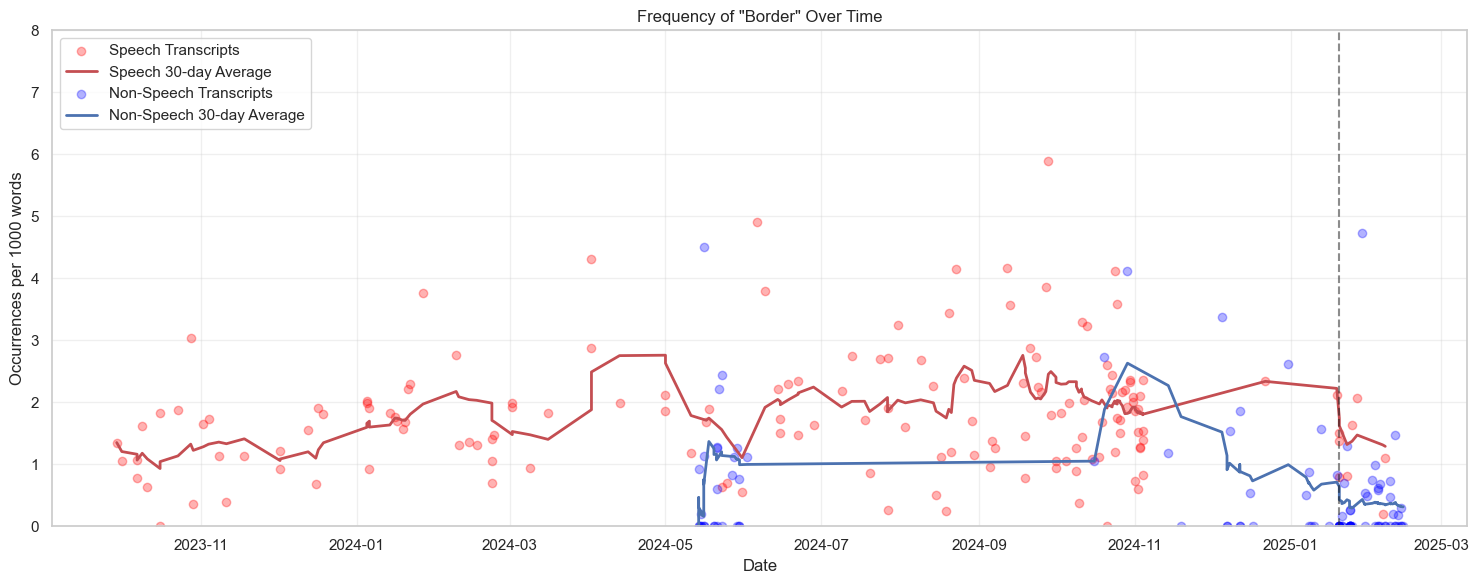

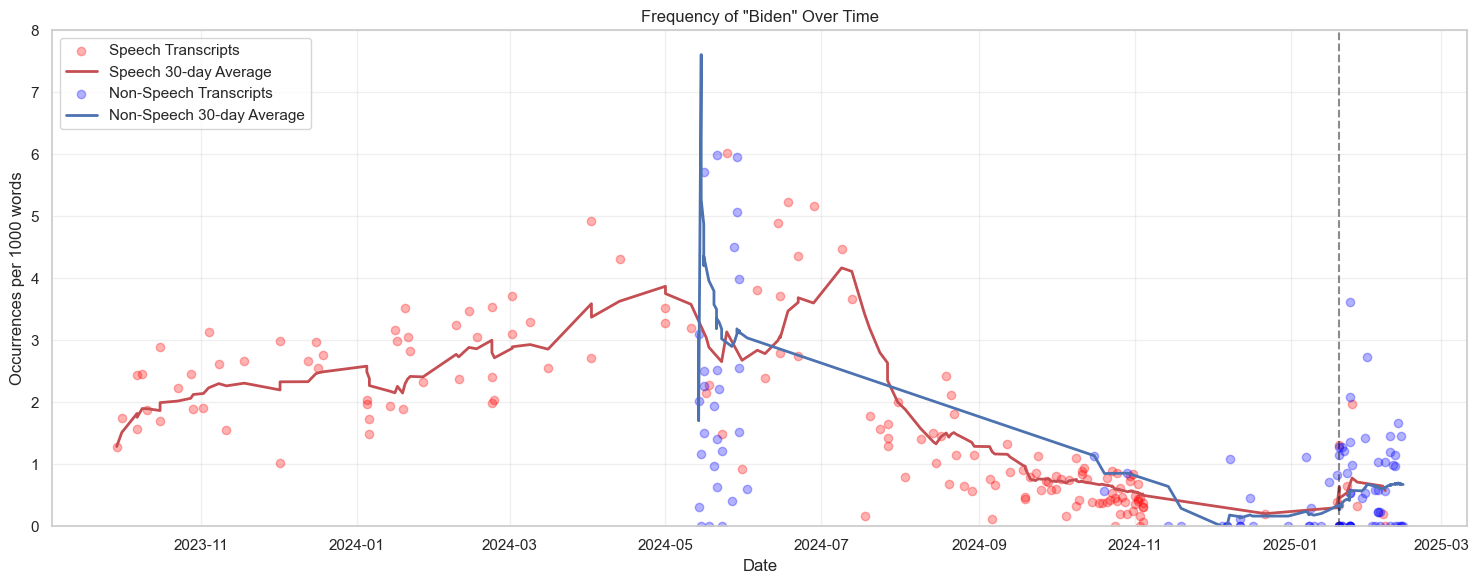

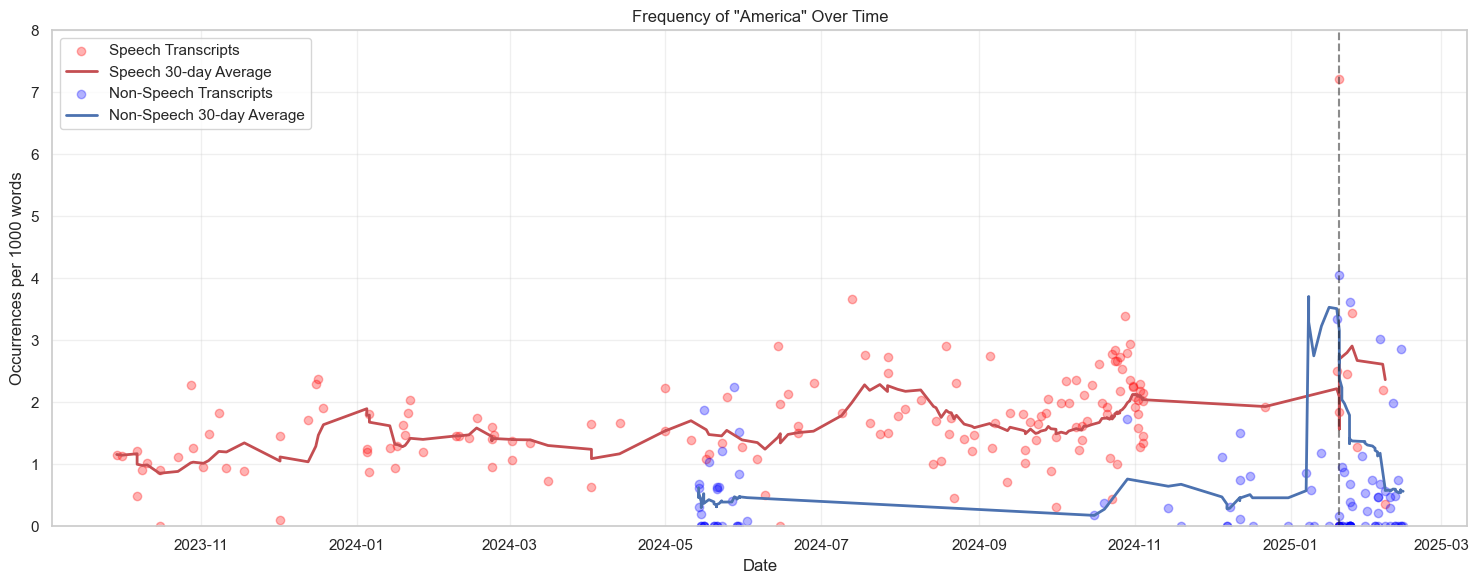

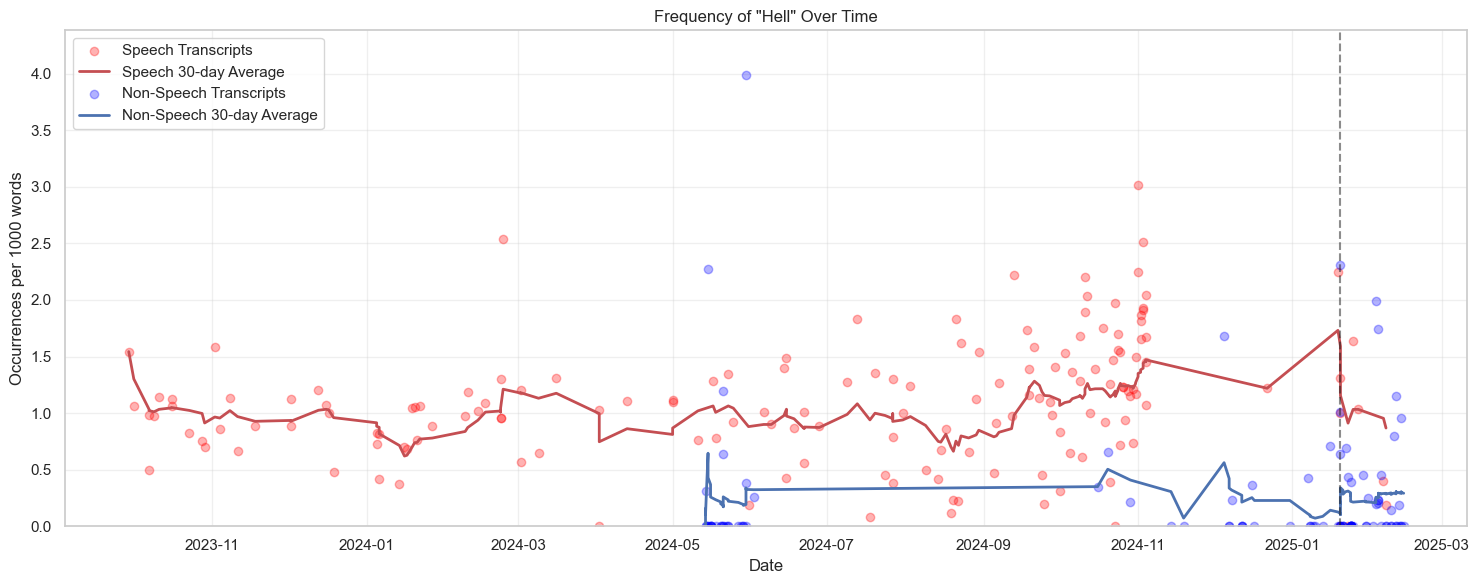

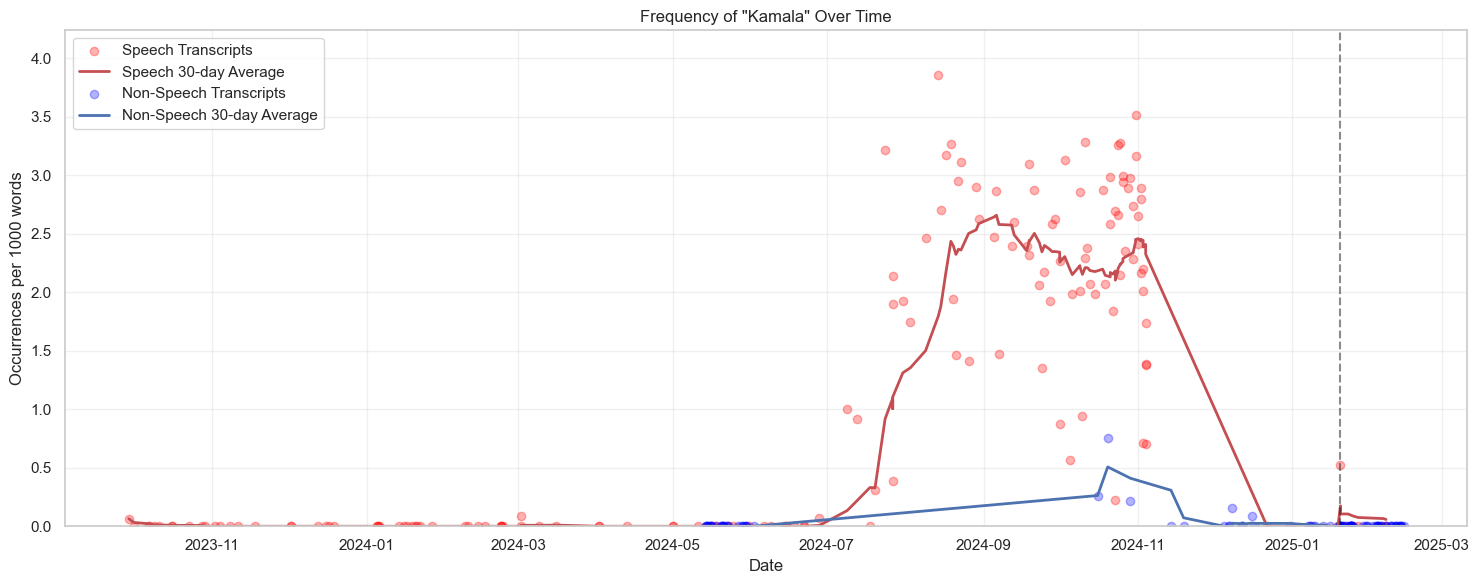

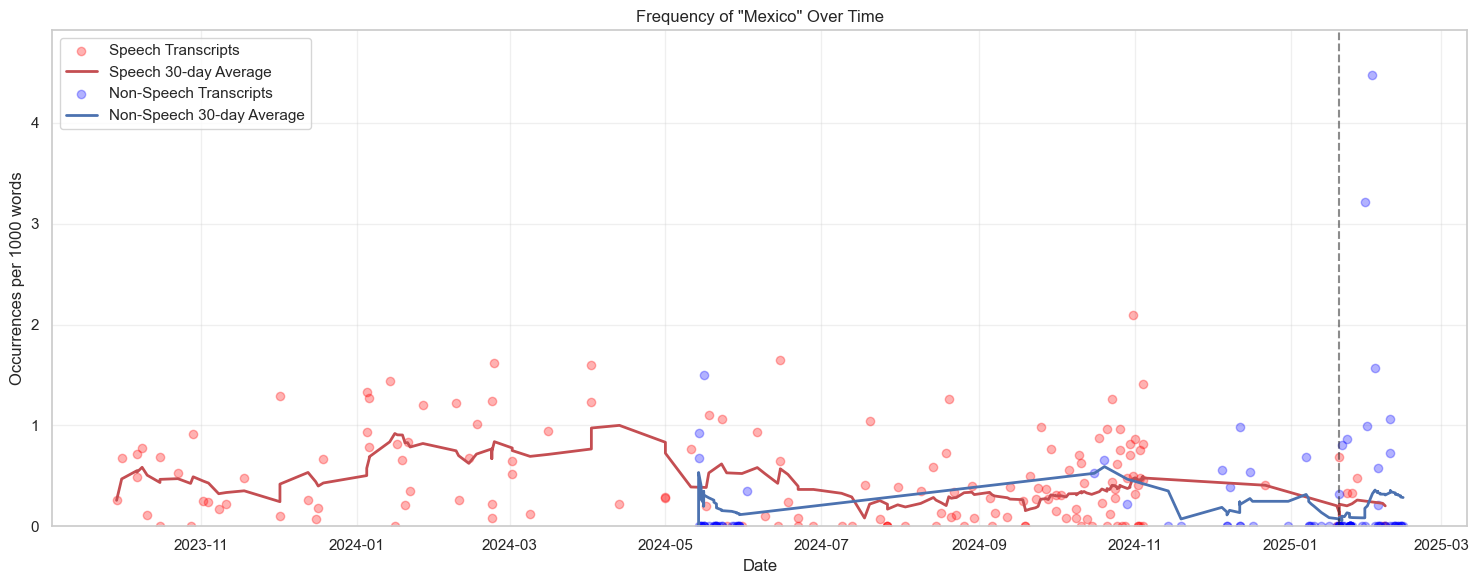

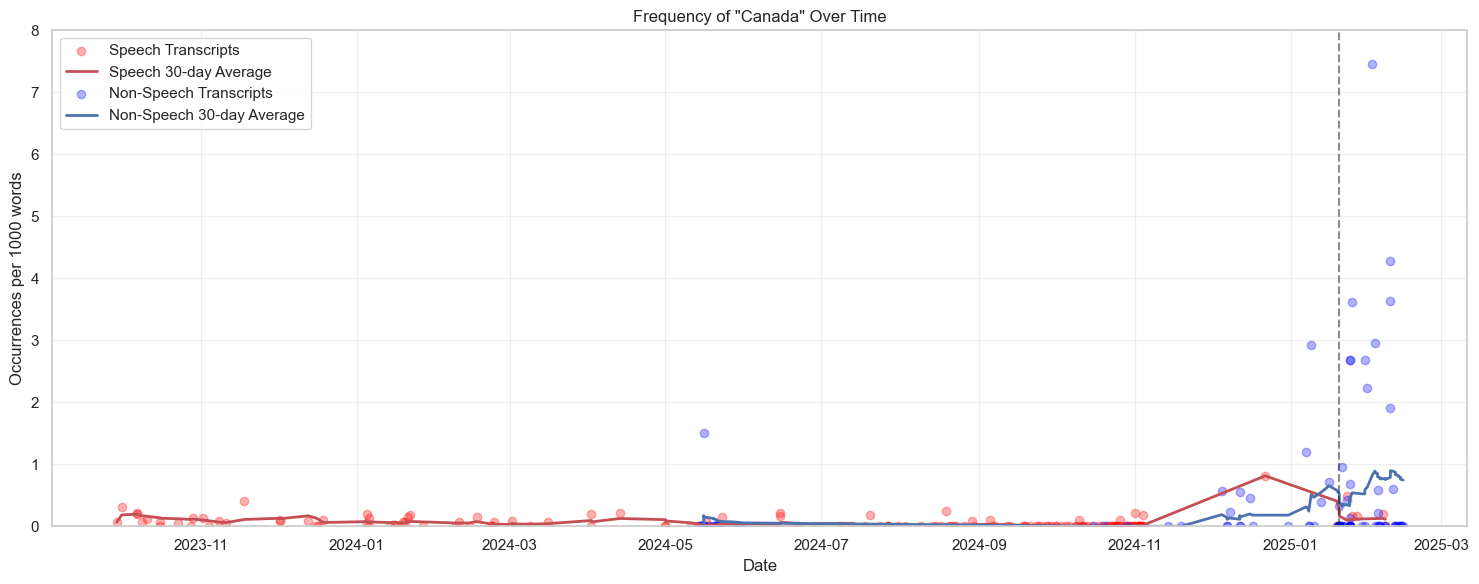

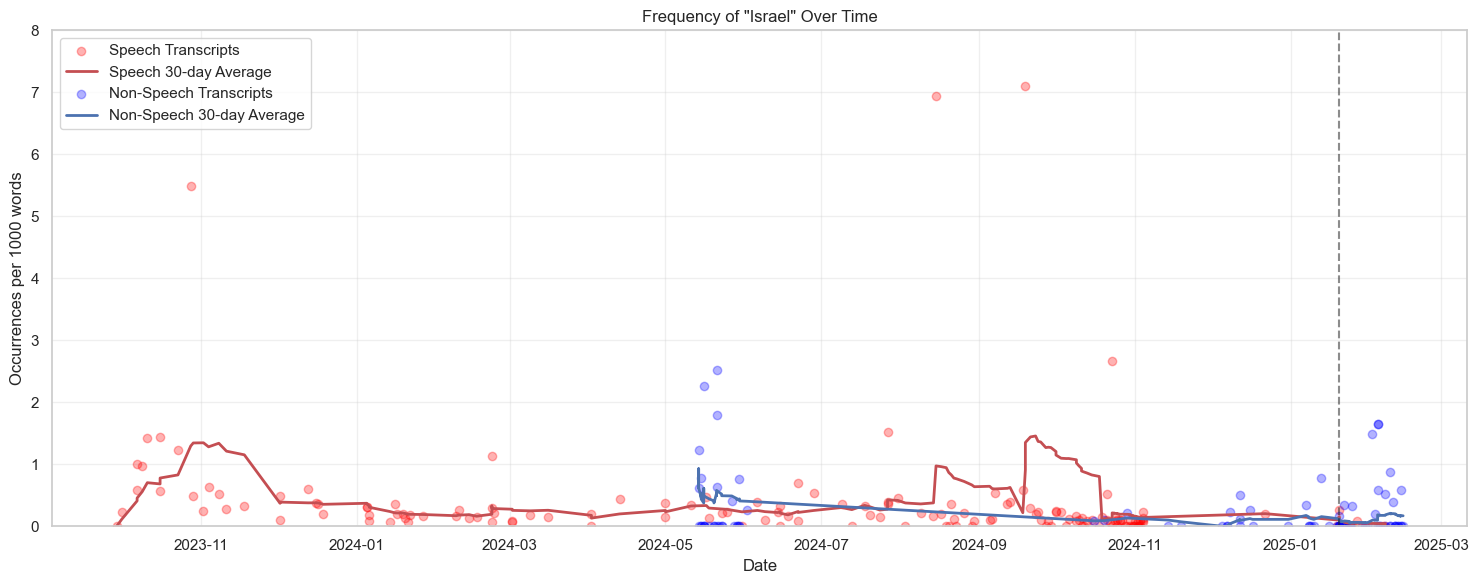

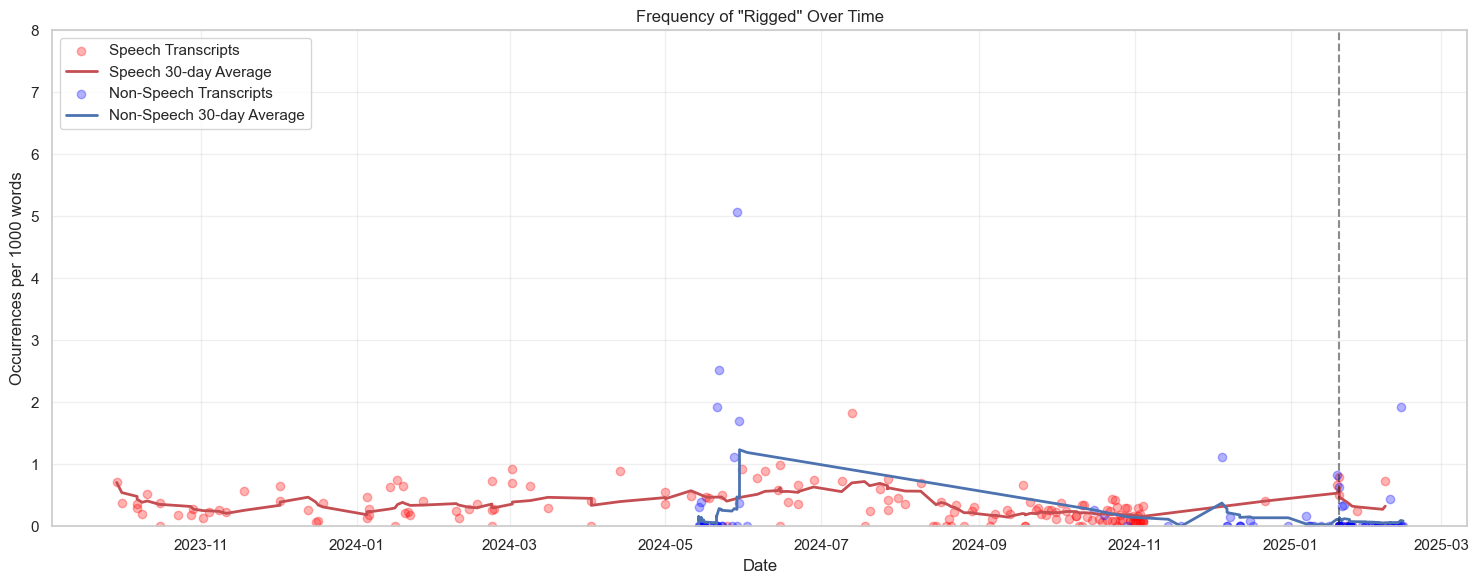

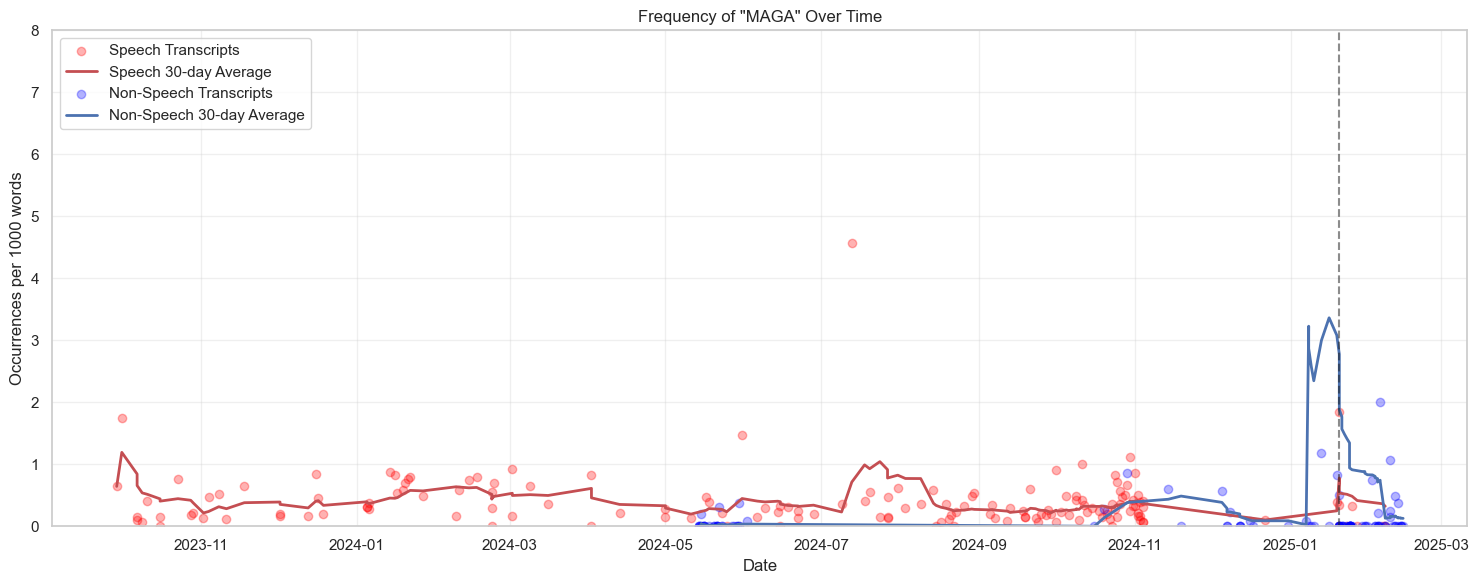

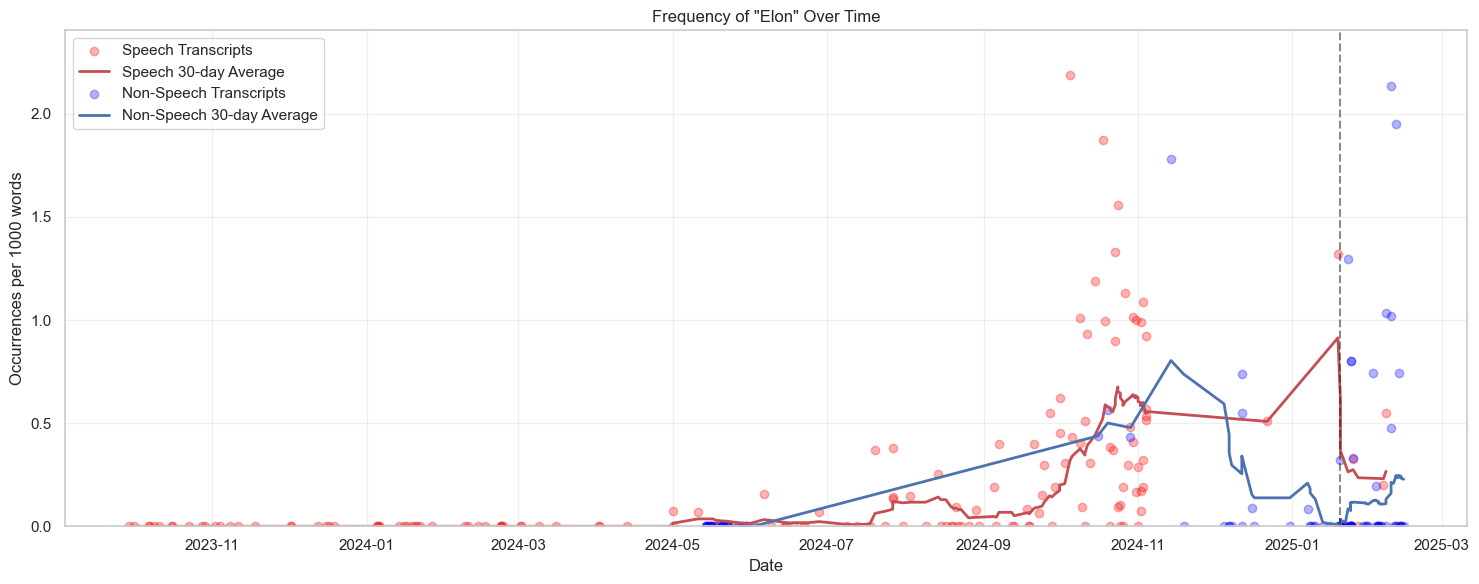

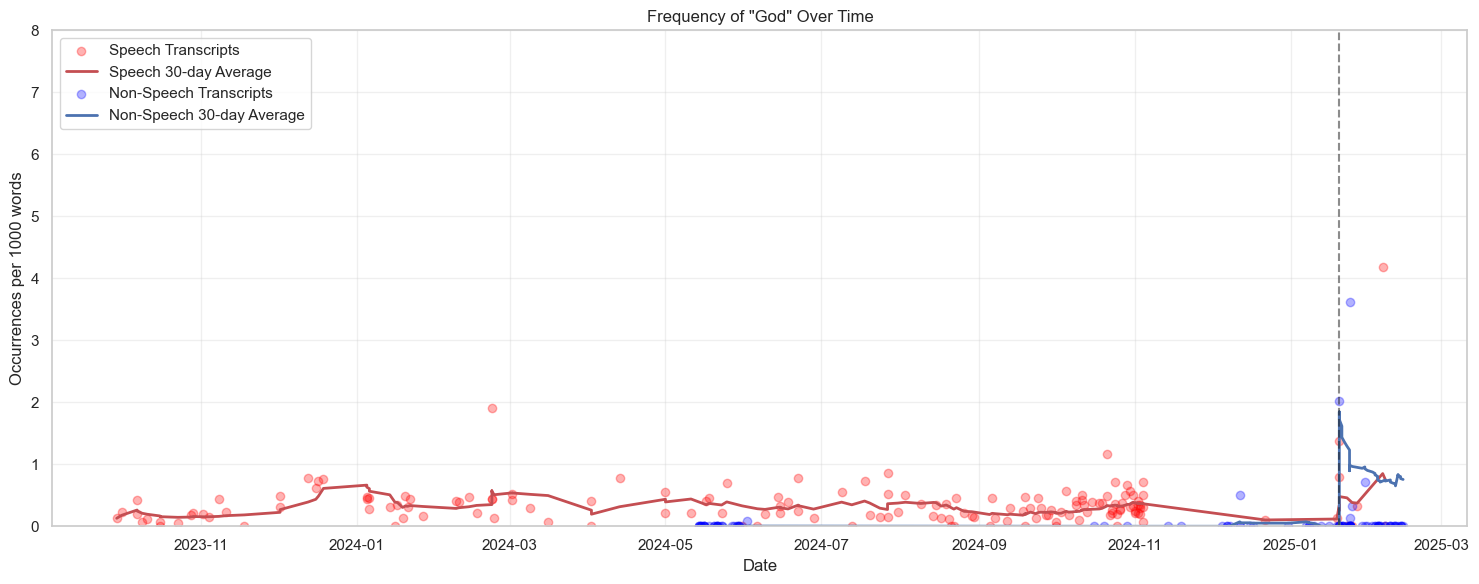

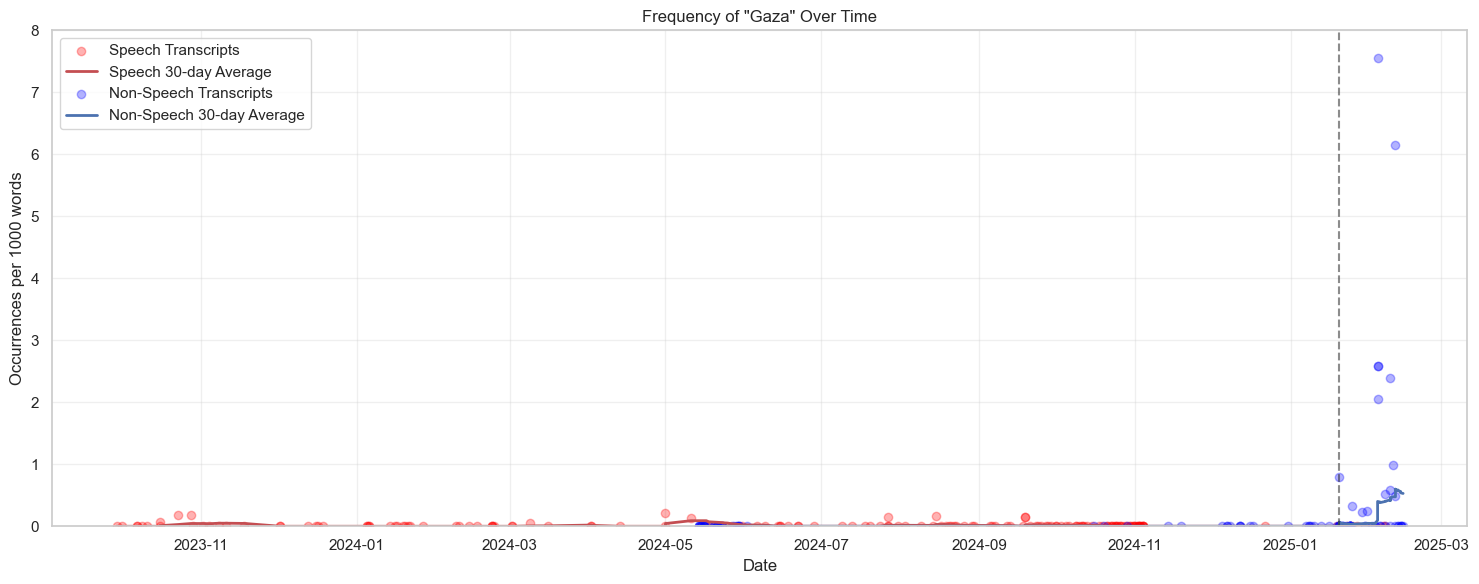

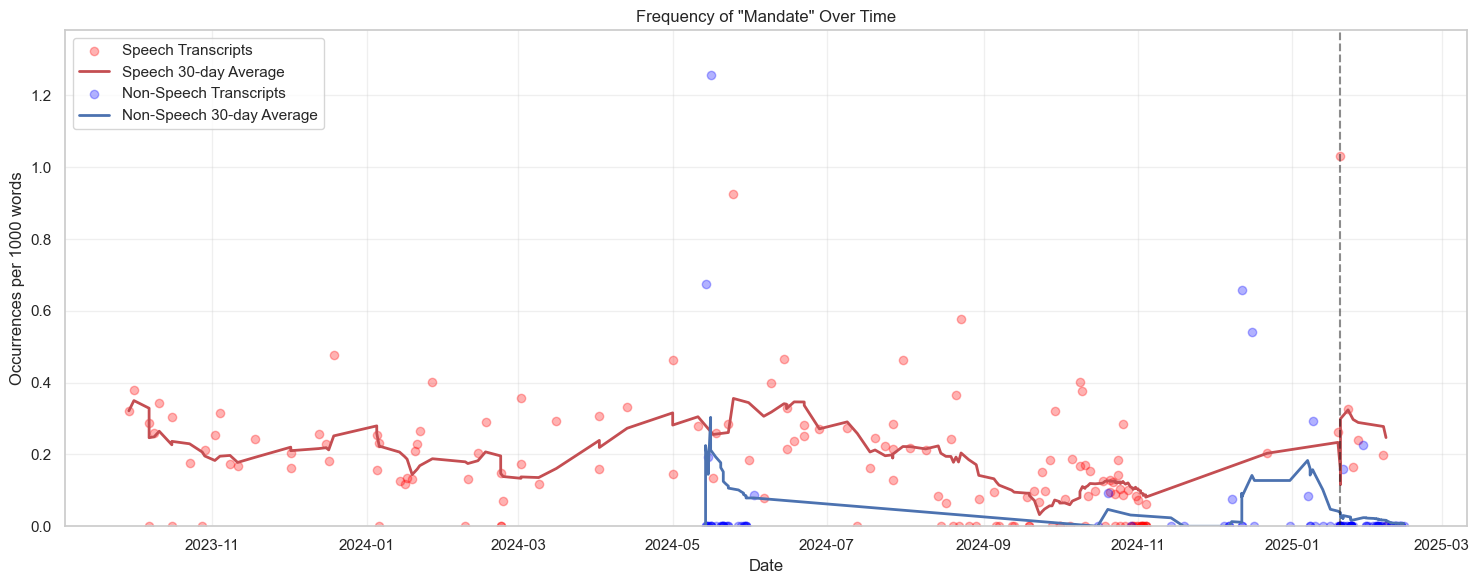

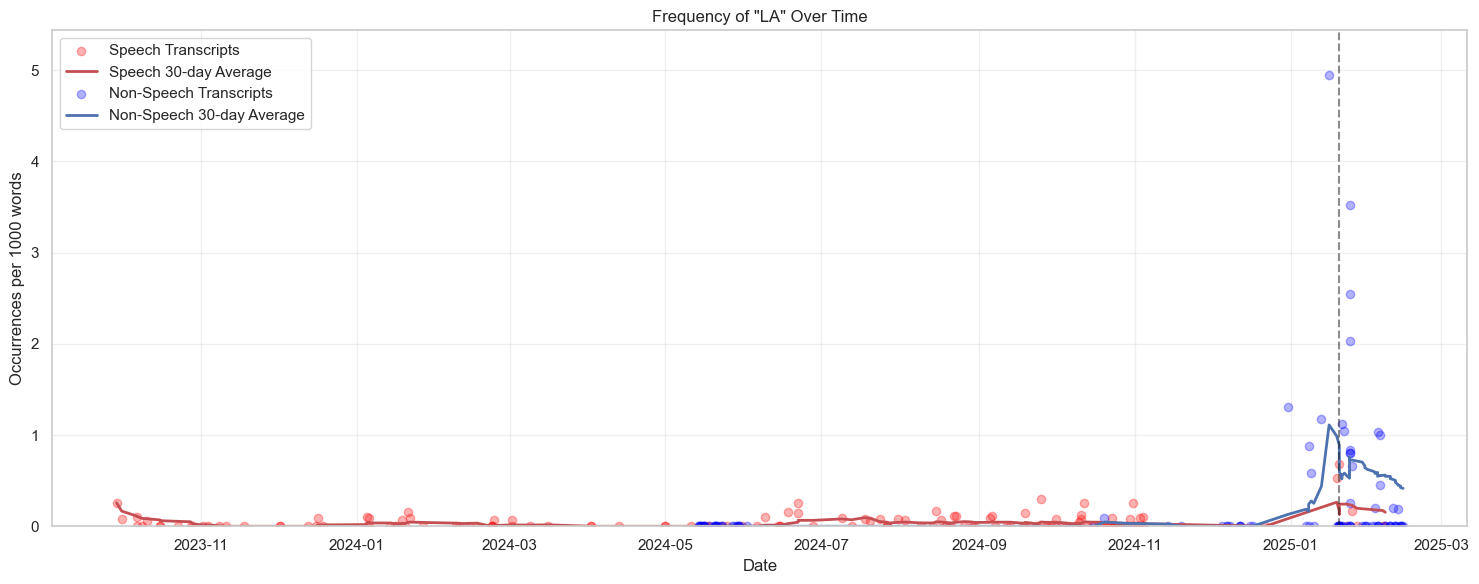

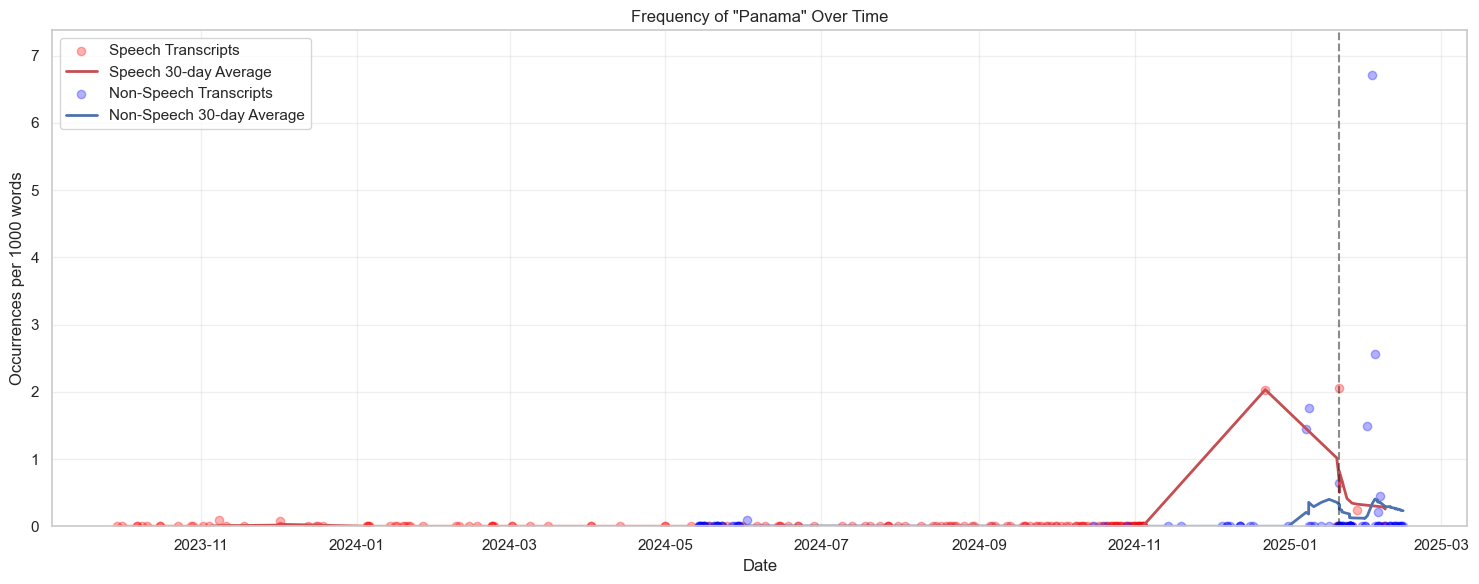

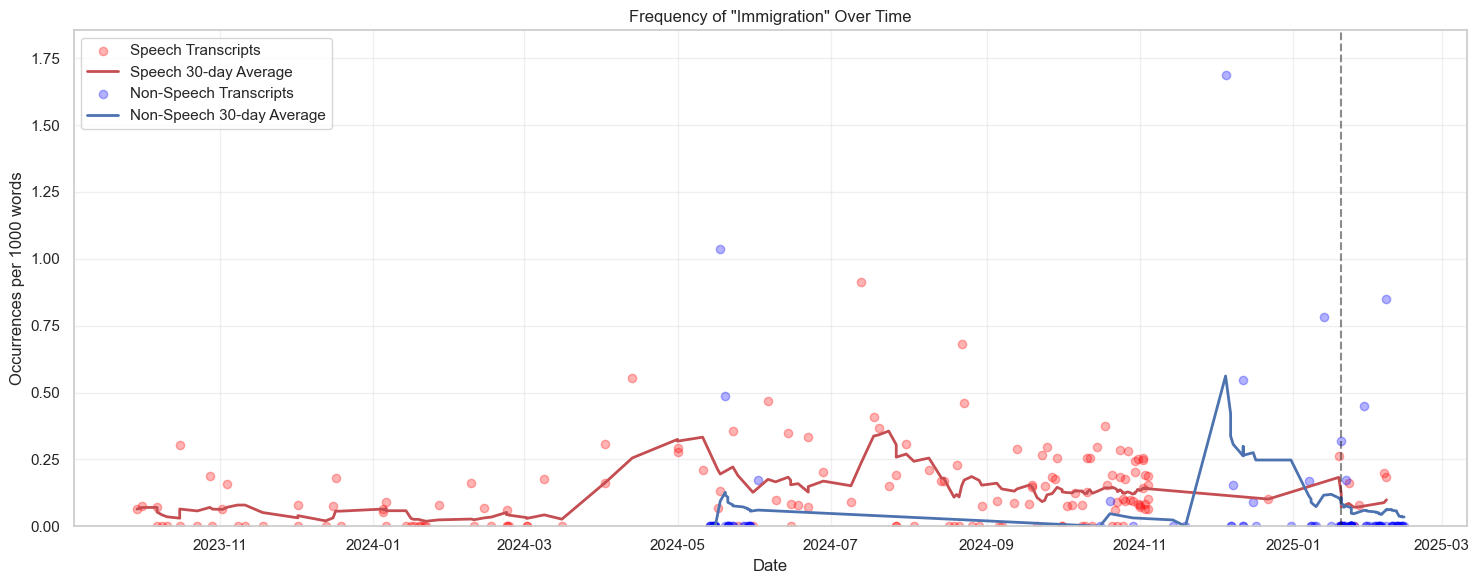

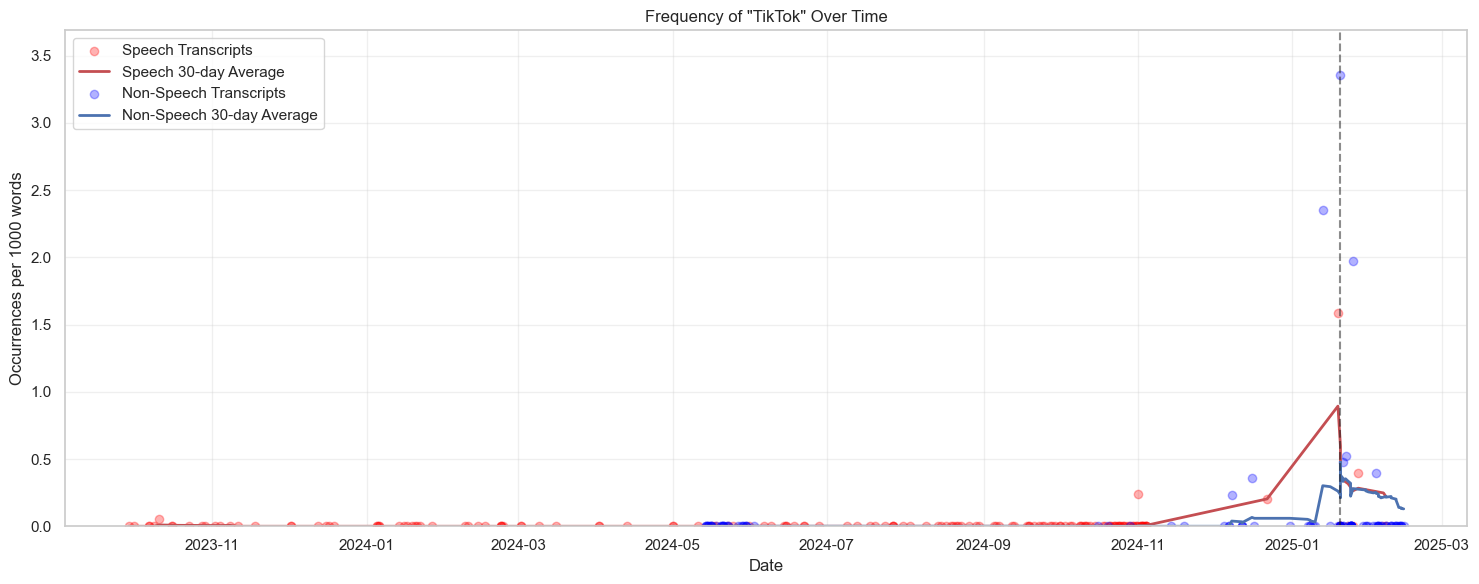

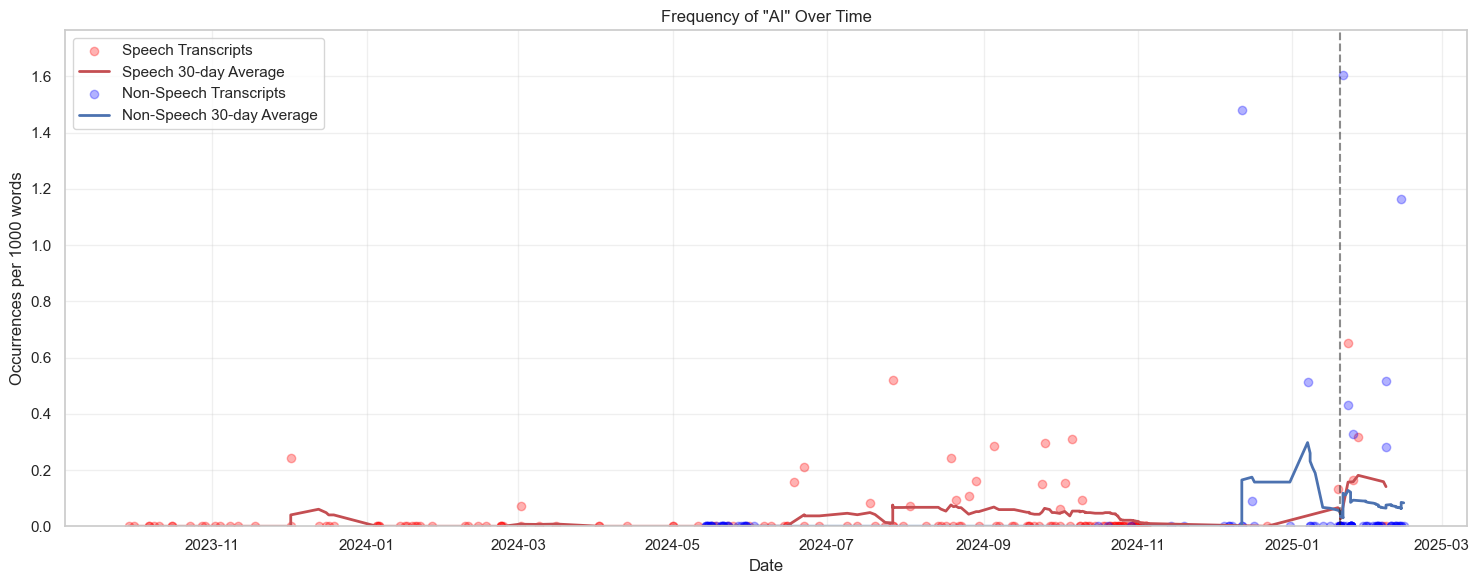

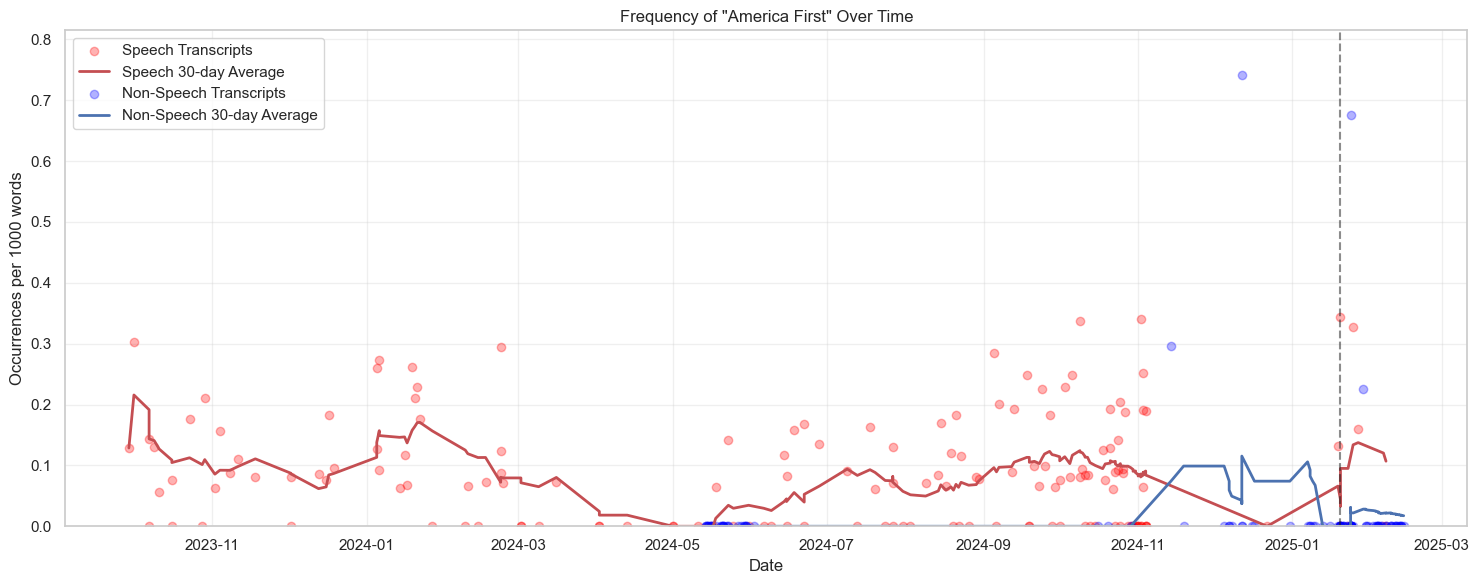

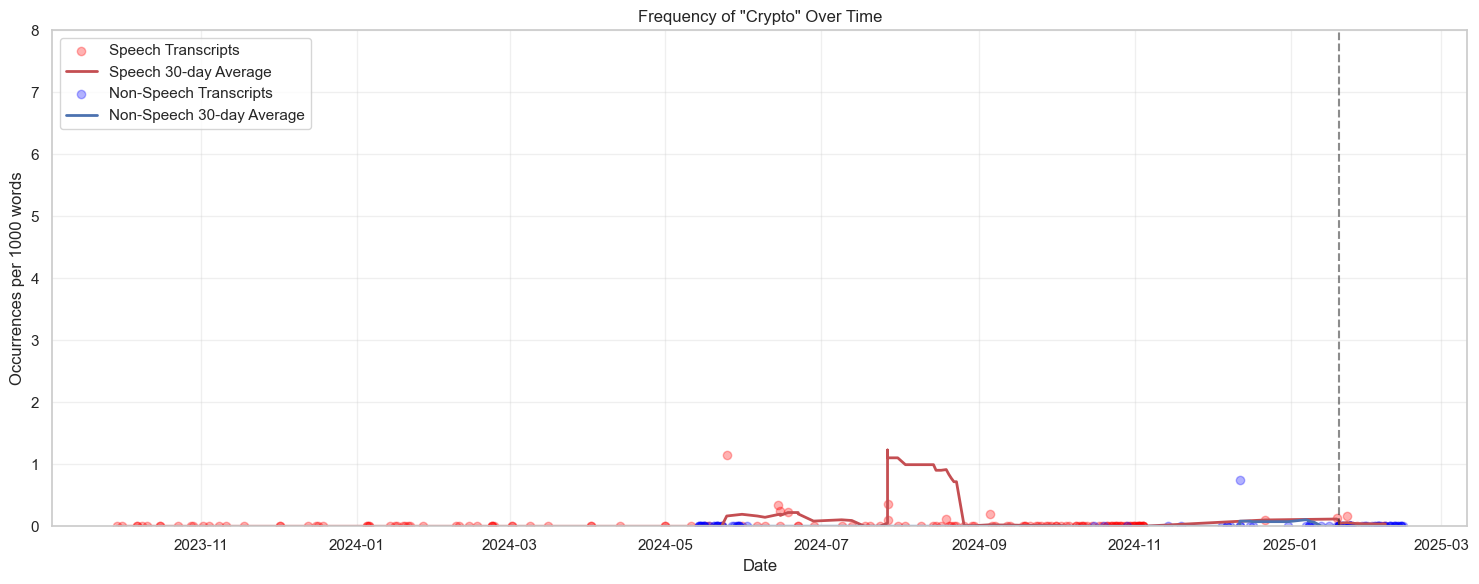

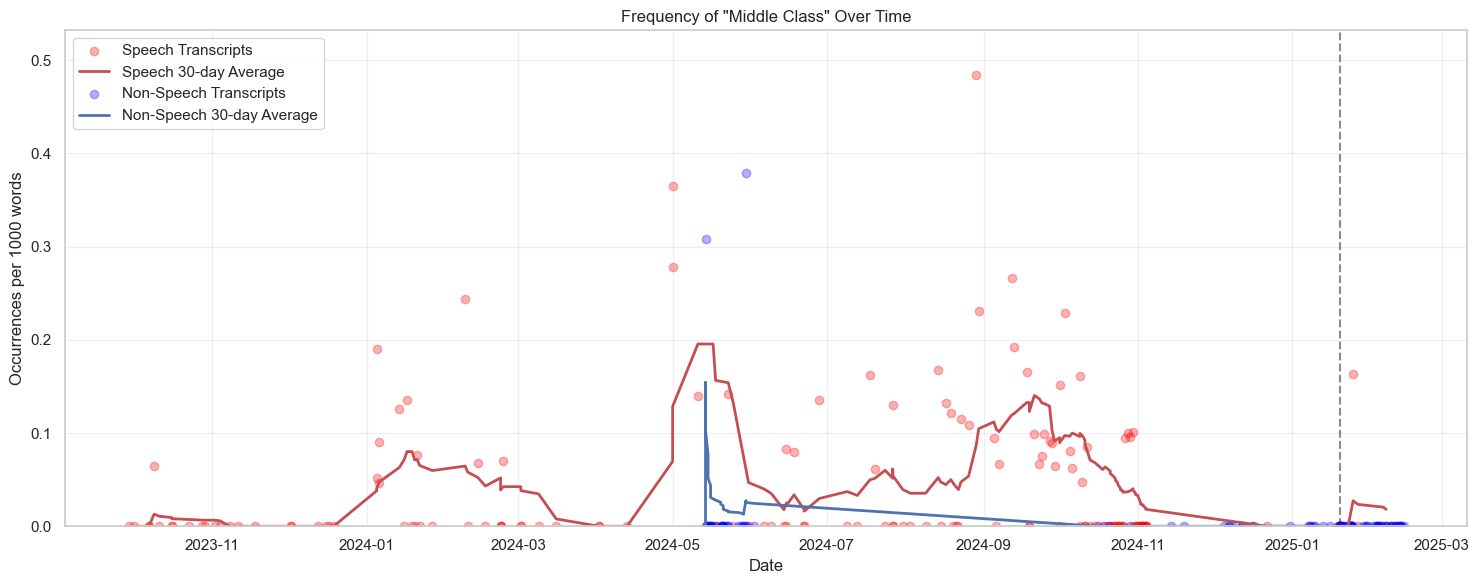

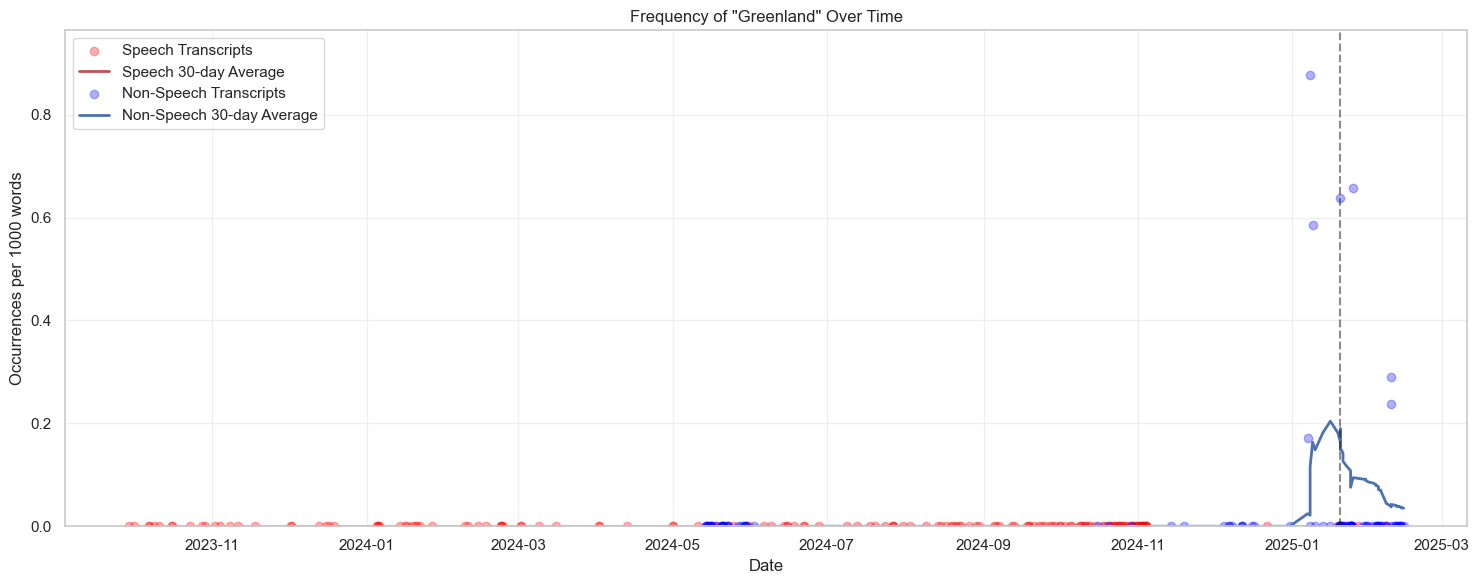

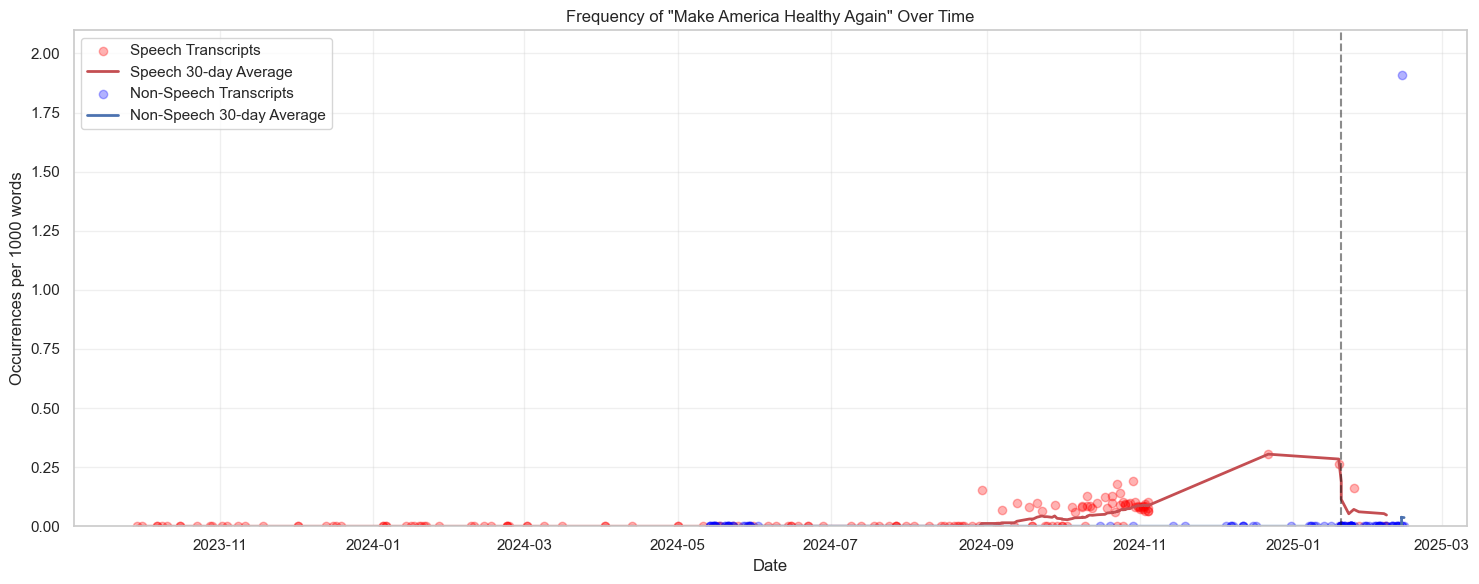

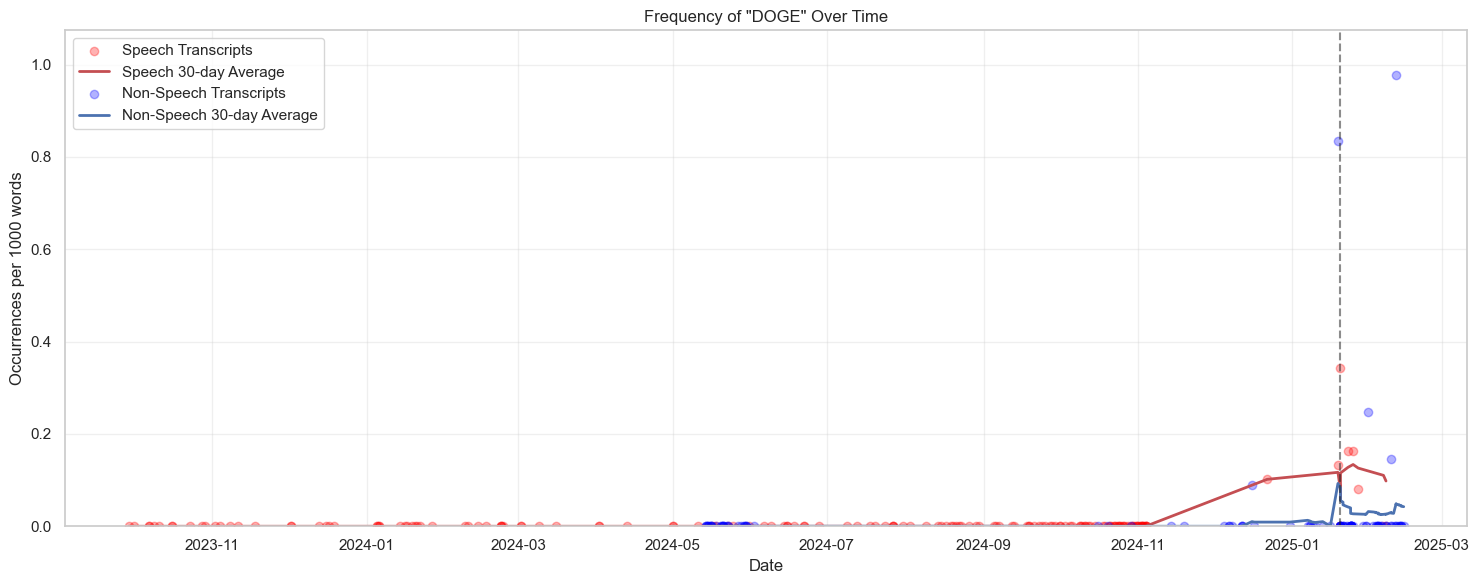

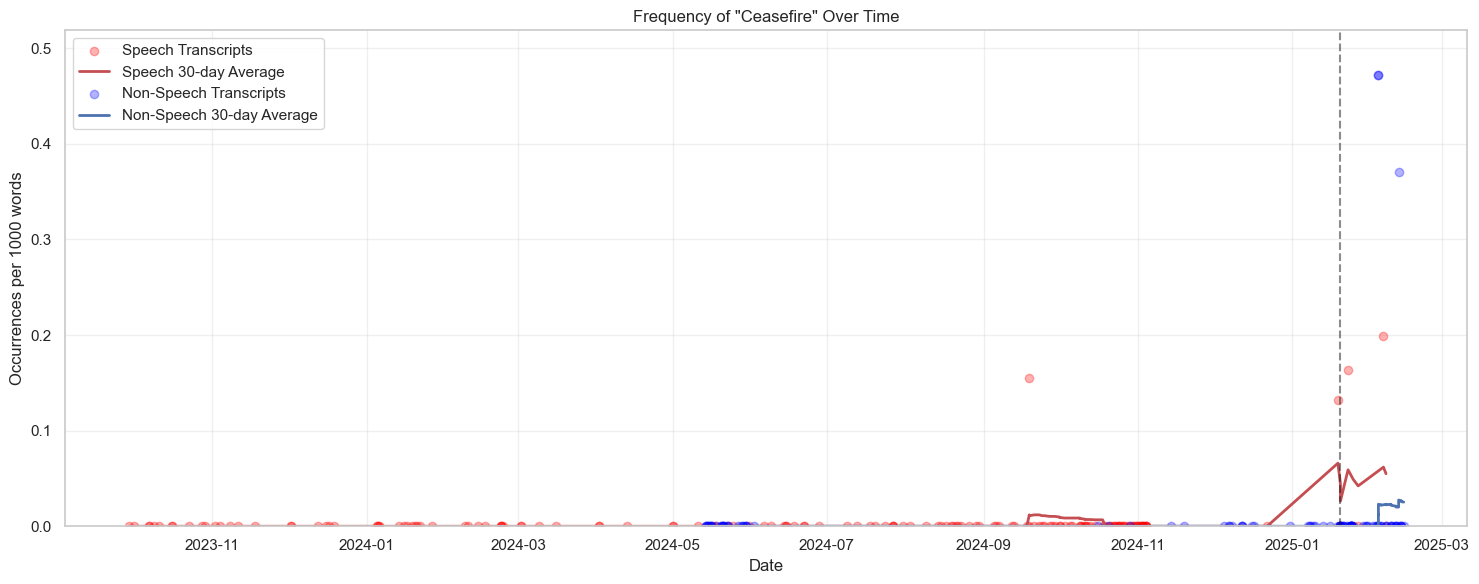

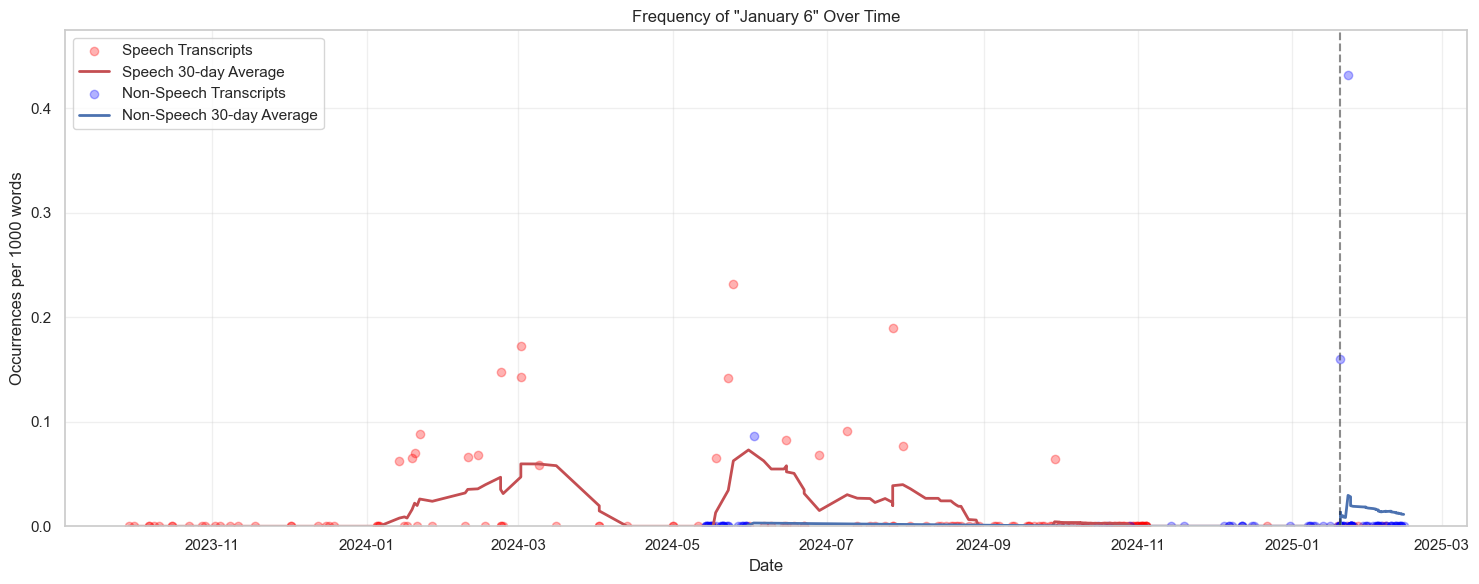

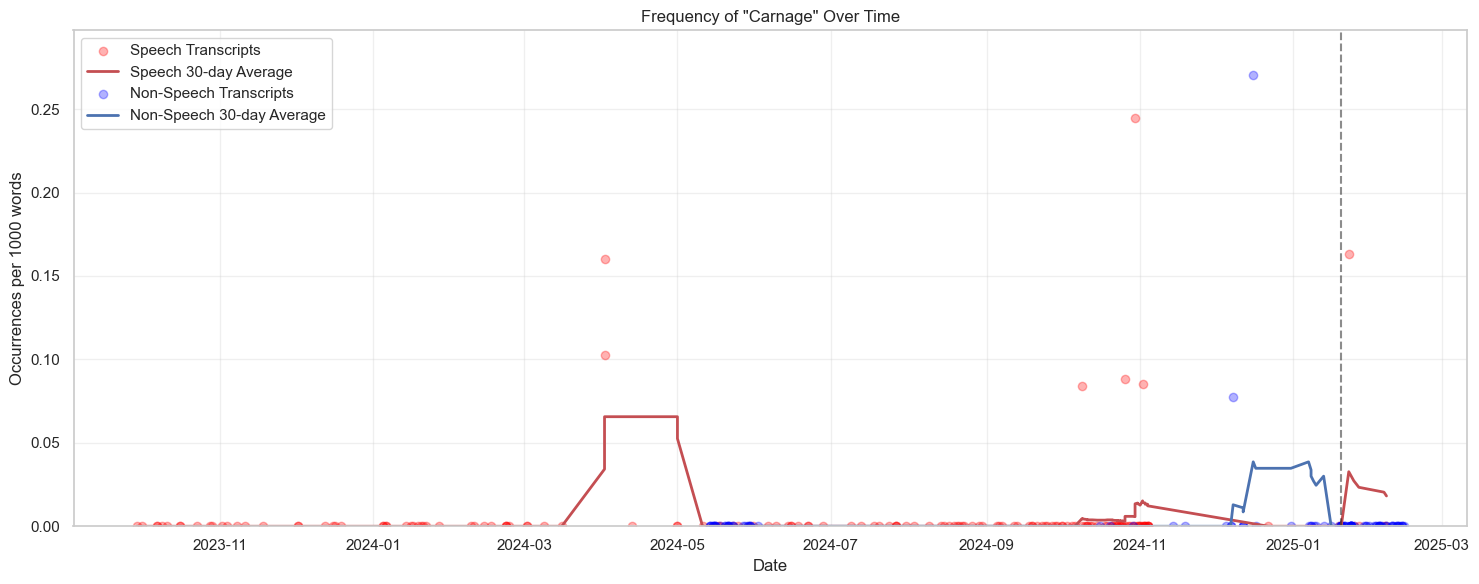

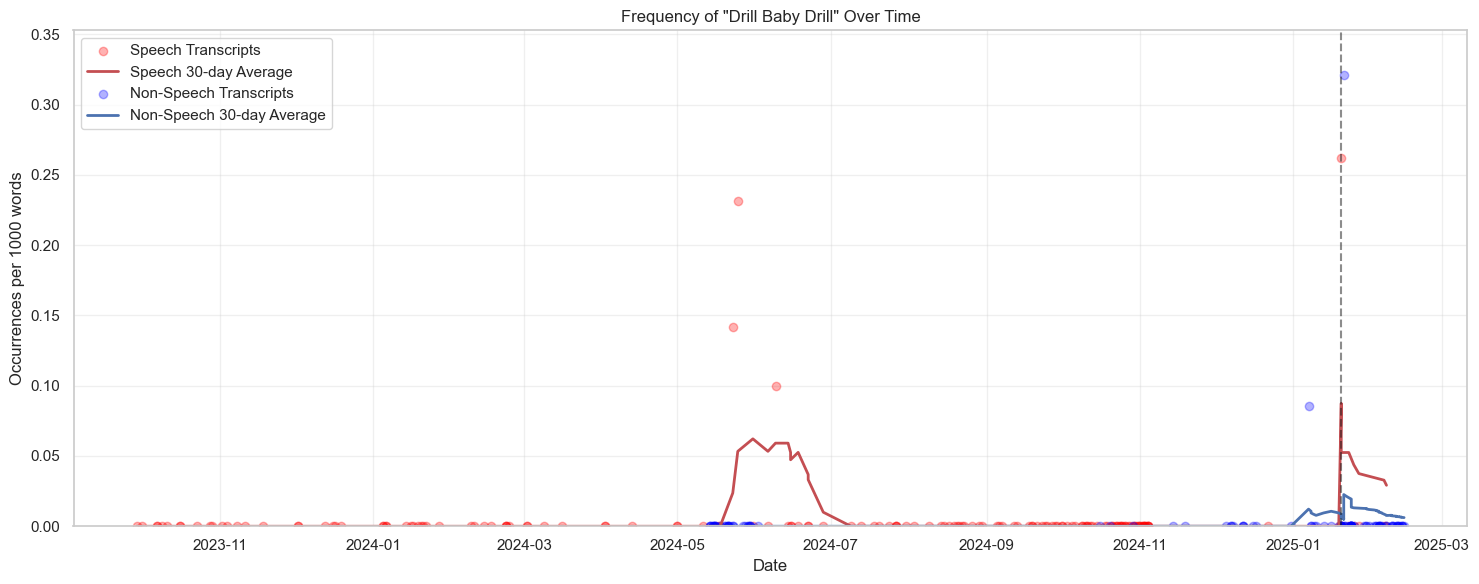

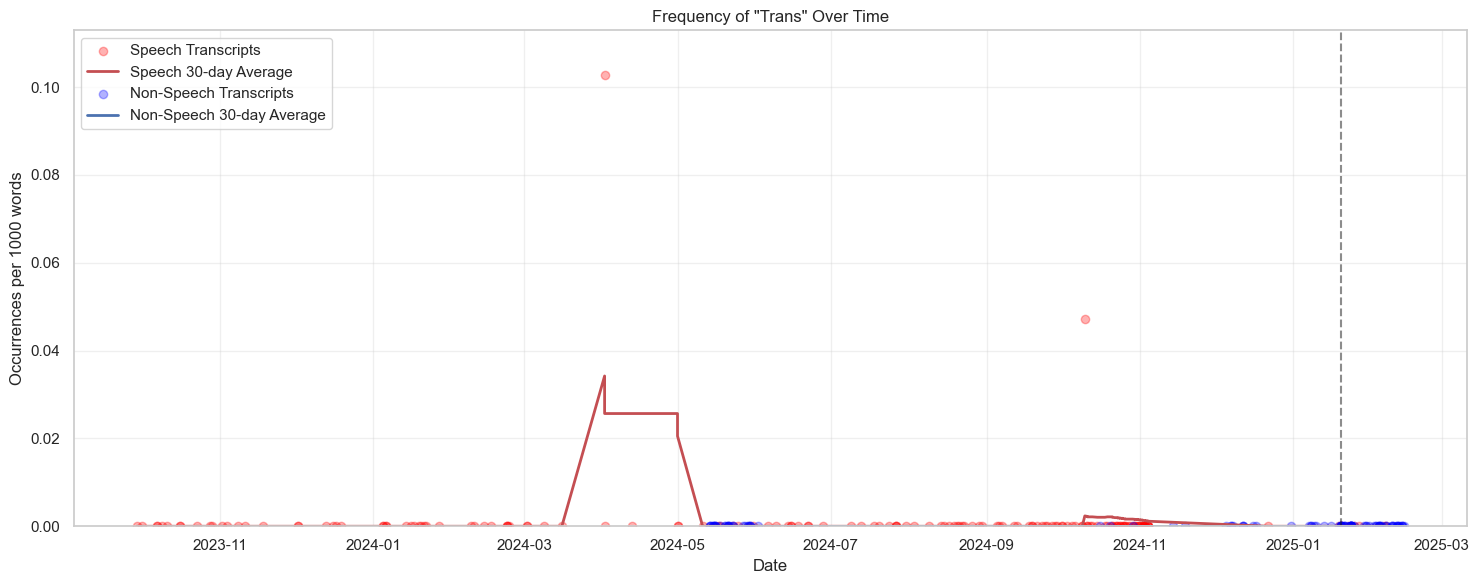

In [78]:
def plot_phrase_frequency_over_time(df_speech, df_non_speech, phrase, window=30):
    """Plot the frequency of a phrase over time with separate lines for speech and non-speech"""
    plt.figure(figsize=(15, 6))
    
    # Process speech data
    df_speech = df_speech.copy()
    df_speech[f'{phrase}_freq'] = (df_speech[phrase] / df_speech['text_length']) * 1000
    speech_series = df_speech.set_index('date')[f'{phrase}_freq']
    speech_rolling = speech_series.rolling(window=f'{window}D', min_periods=1).mean()
    
    # Process non-speech data
    df_non_speech = df_non_speech.copy()
    df_non_speech[f'{phrase}_freq'] = (df_non_speech[phrase] / df_non_speech['text_length']) * 1000
    non_speech_series = df_non_speech.set_index('date')[f'{phrase}_freq']
    non_speech_rolling = non_speech_series.rolling(window=f'{window}D', min_periods=1).mean()
    
    # Plot speech data
    plt.scatter(speech_series.index, speech_series.values, alpha=0.3, color='red', label='Speech Transcripts')
    plt.plot(speech_rolling.index, speech_rolling.values, 'r-', linewidth=2, label=f'Speech {window}-day Average')
    
    # Plot non-speech data
    plt.scatter(non_speech_series.index, non_speech_series.values, alpha=0.3, color='blue', label='Non-Speech Transcripts')
    plt.plot(non_speech_rolling.index, non_speech_rolling.values, 'b-', linewidth=2, label=f'Non-Speech {window}-day Average')
    
    plt.title(f'Frequency of "{phrase}" Over Time')
    plt.xlabel('Date')
    plt.ylabel('Occurrences per 1000 words')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add vertical line for inauguration
    plt.axvline(x=INAUGURATION_DATE, color='k', linestyle='--', alpha=0.5, label='Inauguration')
    
    # Auto-adjust y-axis limit up to max of 8
    ymax = min(8, max(
        df_speech[f'{phrase}_freq'].max(),
        df_non_speech[f'{phrase}_freq'].max()
    ) * 1.1)  # Add 10% padding
    plt.ylim(0, ymax)
    
    plt.tight_layout()
    plt.show()

# Plot time series for all phrases, sorted by frequency
phrase_freqs = {}
for phrase in SEARCH_PHRASES.keys():
    # Calculate average frequency across all data
    speech_freq = (df_speech[phrase].sum() / df_speech['text_length'].sum()) * 1000
    nonspeech_freq = (df_nonspeech[phrase].sum() / df_nonspeech['text_length'].sum()) * 1000
    phrase_freqs[phrase] = (speech_freq + nonspeech_freq) / 2

# Sort phrases by frequency and plot
for phrase in sorted(phrase_freqs, key=phrase_freqs.get, reverse=True):
    plot_phrase_frequency_over_time(df_speech, df_nonspeech, phrase)

## Previous State of the Unions

Relevant for tone, stable phrases and for predicting length of future SOTUs.

In [79]:
# Create a table showing phrase counts for each SOTU
sotu_counts = []

for phrase in SEARCH_PHRASES.keys():
    # Get counts for each SOTU
    counts = df_sotu[['date', phrase]].values.tolist()
    
    # Format into a row with the phrase and counts
    row = {'Phrase': phrase}
    for date, count in counts:
        year = date.year
        row[f'SOTU {year}'] = count
        
    sotu_counts.append(row)

# Convert to DataFrame and display
df_sotu_counts = pd.DataFrame(sotu_counts)
# Sort by average counts across all SOTUs
df_sotu_counts['Average'] = df_sotu_counts[[col for col in df_sotu_counts.columns if 'SOTU' in col]].mean(axis=1)
df_sotu_counts = df_sotu_counts.sort_values('Average', ascending=False)

# Display the table
display(df_sotu_counts.style.format({col: '{:.0f}' for col in df_sotu_counts.columns if 'SOTU' in col}))


,Phrase,SOTU 2017,SOTU 2018,SOTU 2019,SOTU 2020,Average
2,America,31,27,25,38,30.250000
3,Border,6,5,14,9,8.500000
0,Immigration,10,9,6,3,7.000000
8,God,3,4,5,10,5.500000
26,Mexico,0,2,1,3,1.500000
7,Middle Class,3,1,2,0,1.500000
27,Canada,2,0,1,2,1.250000
23,Israel,1,1,1,1,1.000000
21,Mandate,1,2,1,0,1.000000
1,America First,0,1,1,1,0.750000


## Poisson Predictions

The most naive approach is to use the past frequency of a phrase over a given time period to forecast the probability of a phrase occurring during the expected length of a future speech. Using the Poisson distribution, we assume each word is independent and identically distributed. This allows us to compute threshold probabilities for a phrase occurring a given number of times, which can be compared to the prediction market's implied probability. However, this approach does not account for the clear dependence between words in a speech. This approach can still be useful for analyzing mentions where mostly independent occurrences might be expected (America, God, etc.) 

In [96]:
def calculate_poisson_predictions(df, avg_length):
    """Calculate predictions with likelihoods using Poisson distribution"""
    predictions = []
    
    for phrase in SEARCH_PHRASES.keys():
        # Calculate rate per word
        total_occurrences = df[phrase].sum()
        total_words = df['text_length'].sum()
        rate_per_word = total_occurrences / total_words
        
        # Expected occurrences in SOTU
        expected = rate_per_word * avg_length
        
        # Calculate likelihoods using Poisson PMF
        def poisson_ge_k(lambda_, k):
            return 1 - stats.poisson.cdf(k-1, lambda_)
        
        predictions.append({
            'Phrase': phrase,
            'Expected': expected,
            'Historical Rate': rate_per_word * 1000,  # per 1000 words
            'Total Historical': total_occurrences,
            'P(≥1)': poisson_ge_k(expected, 1),
            'P(≥3)': poisson_ge_k(expected, 3),
            'P(≥4)': poisson_ge_k(expected, 4),
            'P(≥5)': poisson_ge_k(expected, 5),
            'P(≥15)': poisson_ge_k(expected, 15)
        })
    
    return pd.DataFrame(predictions)

# Use SOTU average length for predictions
avg_sotu_length = df_sotu['text_length'].mean()

# Calculate predictions from different data sources
predictions_all = calculate_poisson_predictions(df, avg_sotu_length)
predictions_speeches = calculate_poisson_predictions(df_speech, avg_sotu_length)
predictions_post_all = calculate_poisson_predictions(pd.concat([df_nonspeech_post, df_speech_post]), avg_sotu_length)

# Format the tables
def format_prediction_table(df, source):
    formatted = df.copy()
    formatted = formatted.round(2)
    formatted['P(≥1)'] = formatted['P(≥1)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥3)'] = formatted['P(≥3)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥4)'] = formatted['P(≥4)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥5)'] = formatted['P(≥5)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥15)'] = formatted['P(≥15)'].apply(lambda x: f"{x:.1%}")
    
    return formatted[[
        'Phrase', 'Expected',
        'P(≥1)', 'P(≥3)', 'P(≥4)', 'P(≥5)', 'P(≥15)',
        'Historical Rate', 'Total Historical'
    ]].sort_values('Expected', ascending=False)

print("Predictions based on all appearances:")
display(format_prediction_table(predictions_all, 'all'))

print("\nPredictions based on all speeches:")
display(format_prediction_table(predictions_speeches, 'post-inauguration-speeches'))

print("\nPredictions based on all post-inauguration appearances:")
display(format_prediction_table(predictions_post_all, 'post-inauguration-all'))

Predictions based on all appearances:


,Phrase,Expected,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15),Historical Rate,Total Historical
3,Border,9.12,100.0%,99.0%,98.0%,95.0%,5.0%,1.68,3586
11,Biden,8.43,100.0%,99.0%,97.0%,92.0%,3.0%,1.55,3316
2,America,8.30,100.0%,99.0%,97.0%,92.0%,2.0%,1.53,3266
24,Hell,5.37,100.0%,90.0%,78.0%,62.0%,0.0%,0.99,2111
19,Kamala,5.27,99.0%,90.0%,77.0%,61.0%,0.0%,0.97,2074
26,Mexico,2.53,92.0%,46.0%,25.0%,11.0%,0.0%,0.47,996
17,MAGA,1.82,84.0%,27.0%,11.0%,4.0%,0.0%,0.33,715
23,Israel,1.80,83.0%,27.0%,11.0%,4.0%,0.0%,0.33,708
8,God,1.63,80.0%,22.0%,8.0%,3.0%,0.0%,0.30,642
20,Rigged,1.57,79.0%,21.0%,7.0%,2.0%,0.0%,0.29,618



Predictions based on all speeches:


,Phrase,Expected,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15),Historical Rate,Total Historical
3,Border,9.77,100.0%,100.0%,99.0%,97.0%,7.0%,1.80,3317
11,Biden,8.99,100.0%,99.0%,98.0%,94.0%,4.0%,1.66,3051
2,America,8.83,100.0%,99.0%,98.0%,94.0%,4.0%,1.63,2998
19,Kamala,6.07,100.0%,94.0%,85.0%,72.0%,0.0%,1.12,2059
24,Hell,5.98,100.0%,94.0%,85.0%,71.0%,0.0%,1.10,2030
26,Mexico,2.64,93.0%,49.0%,27.0%,13.0%,0.0%,0.49,897
17,MAGA,2.00,86.0%,32.0%,14.0%,5.0%,0.0%,0.37,678
23,Israel,1.86,84.0%,29.0%,12.0%,4.0%,0.0%,0.34,631
8,God,1.78,83.0%,26.0%,11.0%,4.0%,0.0%,0.33,605
20,Rigged,1.66,81.0%,23.0%,9.0%,3.0%,0.0%,0.31,564



Predictions based on all post-inauguration appearances:


,Phrase,Expected,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15),Historical Rate,Total Historical
2,America,4.96,99.0%,87.0%,73.0%,55.0%,0.0%,0.91,163
11,Biden,4.38,99.0%,81.0%,64.0%,45.0%,0.0%,0.81,144
27,Canada,3.96,98.0%,76.0%,56.0%,36.0%,0.0%,0.73,130
3,Border,3.78,98.0%,73.0%,52.0%,33.0%,0.0%,0.70,124
29,Gaza,2.74,94.0%,52.0%,29.0%,14.0%,0.0%,0.50,90
24,Hell,2.41,91.0%,43.0%,22.0%,10.0%,0.0%,0.44,79
26,Mexico,1.61,80.0%,22.0%,8.0%,2.0%,0.0%,0.30,53
8,God,1.37,75.0%,16.0%,5.0%,1.0%,0.0%,0.25,45
28,Panama,1.34,74.0%,15.0%,5.0%,1.0%,0.0%,0.25,44
13,LA,1.34,74.0%,15.0%,5.0%,1.0%,0.0%,0.25,44


## Negative Binomial 

A more general model that accounts for overdispersion. The dispersion parameter r is estimated using the method of moments, and it controls how much extra variance there is compared to a Poisson distribution. As r approaches infinity, the negative binomial converges to a Poisson distribution (in practice we use r=100 to approximate this). Values closer to 0 indicate that the data is overdispersed.

Negative Binomial Predictions based on all appearances:


,Phrase,Expected,Dispersion (r),Sample Variance,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15)
3,Border,9.12,2.13,48.13,97.1%,85.8%,78.7%,71.4%,18.6%
11,Biden,8.43,0.66,116.17,82.3%,63.1%,56.2%,50.4%,19.3%
2,America,8.30,0.72,103.81,83.8%,64.6%,57.5%,51.5%,18.8%
24,Hell,5.37,3.23,14.28,95.8%,75.9%,63.7%,51.7%,2.5%
19,Kamala,5.27,0.86,37.74,81.5%,56.9%,48.0%,40.6%,8.1%
26,Mexico,2.53,1.14,8.16,73.6%,37.6%,26.6%,18.7%,0.5%
17,MAGA,1.82,0.10,77.26,25.6%,14.8%,12.4%,10.6%,3.5%
23,Israel,1.80,0.13,26.46,29.7%,16.6%,13.6%,11.4%,3.1%
8,God,1.63,0.10,75.47,24.8%,14.1%,11.6%,9.9%,3.0%
20,Rigged,1.57,0.10,49.51,24.5%,13.8%,11.4%,9.6%,2.8%


Negative Binomial Predictions based on all speeches:


,Phrase,Expected,Dispersion (r),Sample Variance,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15)
3,Border,9.77,3.80,34.90,99.2%,93.3%,88.1%,81.7%,19.0%
11,Biden,8.99,1.99,49.61,96.7%,84.5%,77.3%,69.9%,18.3%
2,America,8.83,7.24,19.62,99.7%,95.7%,90.9%,84.2%,10.8%
19,Kamala,6.07,0.89,47.27,84.0%,61.3%,52.7%,45.4%,10.7%
24,Hell,5.98,12.86,8.76,99.3%,89.6%,79.2%,66.2%,0.8%
26,Mexico,2.64,2.27,5.72,82.7%,42.9%,28.6%,18.5%,0.1%
17,MAGA,2.00,0.97,6.10,66.2%,29.5%,19.7%,13.2%,0.2%
23,Israel,1.86,0.10,39.14,25.7%,15.0%,12.6%,10.8%,3.6%
8,God,1.78,1.05,4.80,64.8%,26.4%,16.8%,10.6%,0.1%
20,Rigged,1.66,5.59,2.16,76.7%,24.2%,11.1%,4.6%,0.0%


Negative Binomial Predictions based on all appearances post inauguration:


,Phrase,Expected,Dispersion (r),Sample Variance,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15)
2,America,4.96,0.51,53.21,70.2%,47.0%,39.8%,34.1%,9.2%
11,Biden,4.38,1.48,17.40,86.9%,59.2%,47.6%,37.9%,3.0%
27,Canada,3.96,0.28,59.67,53.4%,33.8%,28.6%,24.6%,7.7%
3,Border,3.78,1.03,17.56,79.6%,49.8%,39.3%,31.0%,2.8%
29,Gaza,2.74,0.14,55.76,34.7%,21.2%,17.9%,15.5%,5.5%
24,Hell,2.40,0.84,9.26,67.9%,34.2%,24.7%,17.8%,0.8%
26,Mexico,1.61,0.17,17.30,32.6%,17.0%,13.5%,11.0%,2.2%
8,God,1.37,0.10,332.21,23.6%,12.8%,10.4%,8.7%,2.3%
28,Panama,1.34,0.10,28.49,23.4%,12.6%,10.3%,8.5%,2.2%
13,LA,1.34,0.15,13.13,29.4%,14.7%,11.5%,9.2%,1.7%



Model Comparison (Negative Binomial vs Poisson):


,Phrase,Expected,Poisson P(≥1),NB P(≥1),Δ P(≥1),Poisson P(≥5),NB P(≥5),Δ P(≥5),Dispersion (r),Sample Variance
28,Panama,1.019,63.9%,6.3%,-57.610,0.4%,0.1%,-0.299,0.100,1.560
5,AI,1.019,63.9%,10.5%,-53.428,0.4%,0.1%,-0.301,0.216,0.241
15,TikTok,0.566,43.2%,5.0%,-38.175,0.0%,0.0%,0.008,0.100,0.512
4,DOGE,0.453,36.4%,1.6%,-34.797,0.0%,0.0%,-0.011,0.100,0.037
27,Canada,0.792,54.7%,21.8%,-32.918,0.1%,0.0%,-0.119,1.652,0.308
8,God,3.622,97.3%,64.8%,-32.560,29.8%,10.6%,-19.154,1.053,4.799
6,Ceasefire,0.226,20.3%,1.1%,-19.150,0.0%,0.0%,-0.000,0.100,0.020
13,LA,0.340,28.8%,14.9%,-13.886,0.0%,0.0%,0.018,0.665,0.233
9,Elon,0.679,49.3%,39.1%,-10.215,0.1%,6.7%,6.582,0.351,4.478
10,Drill Baby Drill,0.113,10.7%,1.4%,-9.337,0.0%,0.0%,0.000,0.100,0.028



Distribution comparison for America (r = 7.23):


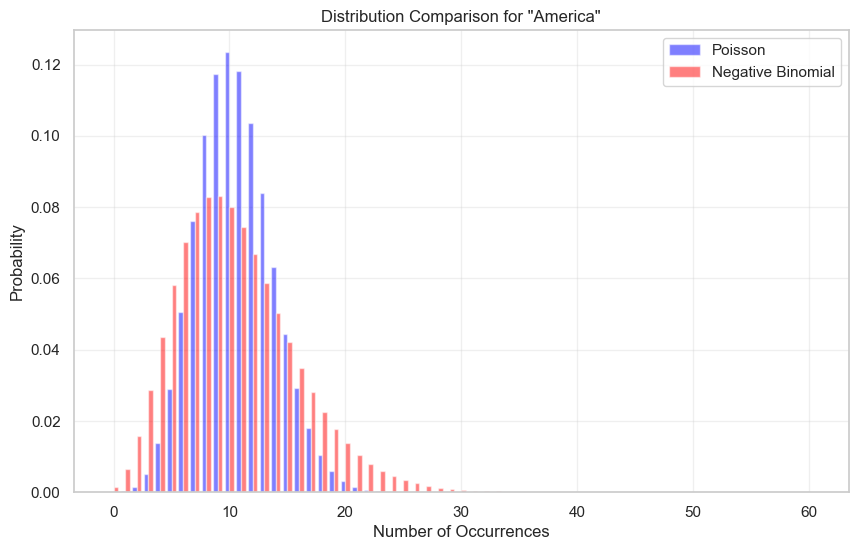


Distribution comparison for Border (r = 3.80):


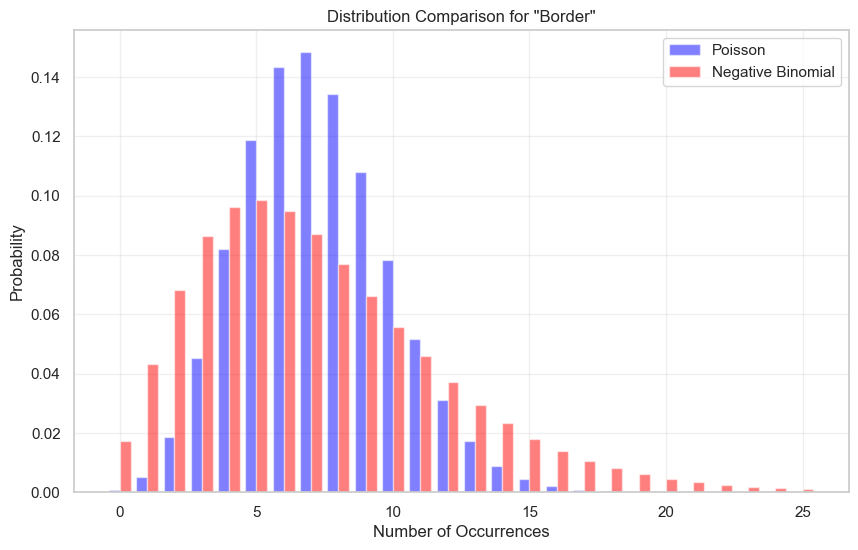


Distribution comparison for God (r = 1.05):


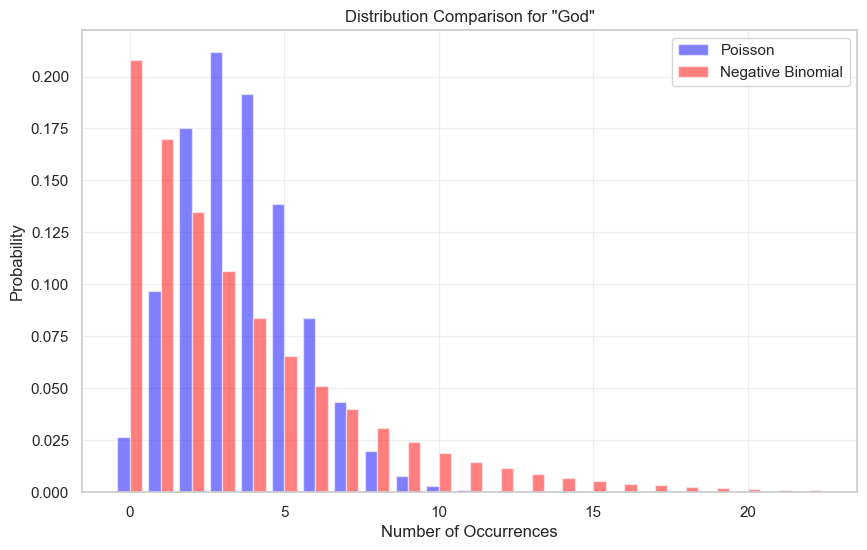


Distribution comparison for LA (r = 0.67):


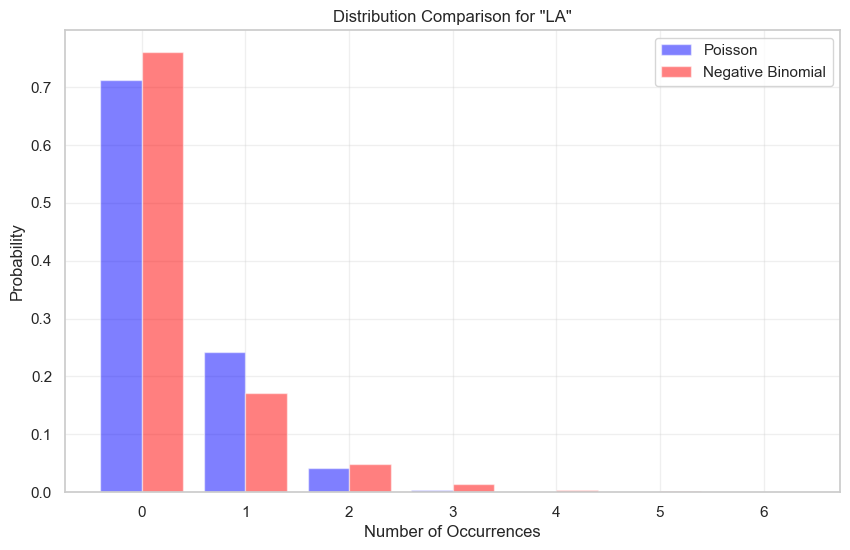


Distribution comparison for January 6 (r = 100.00):


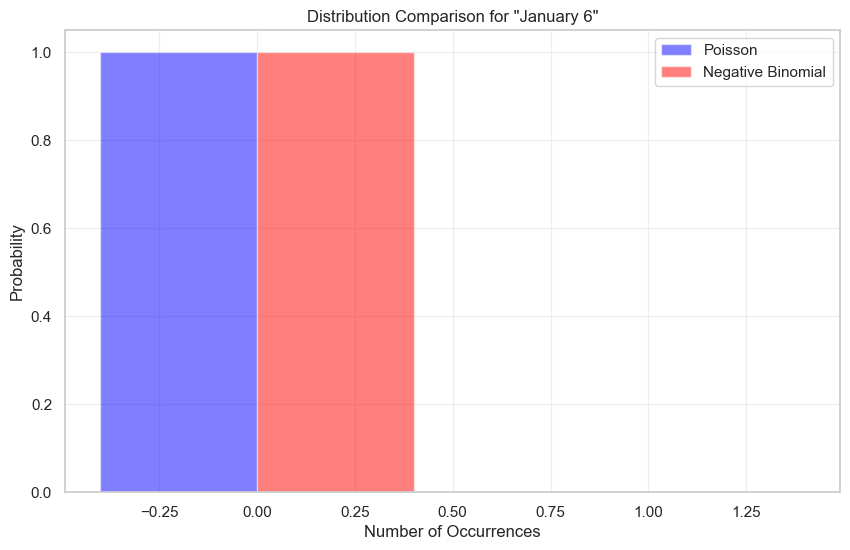


Distribution comparison for MAGA (r = 0.97):


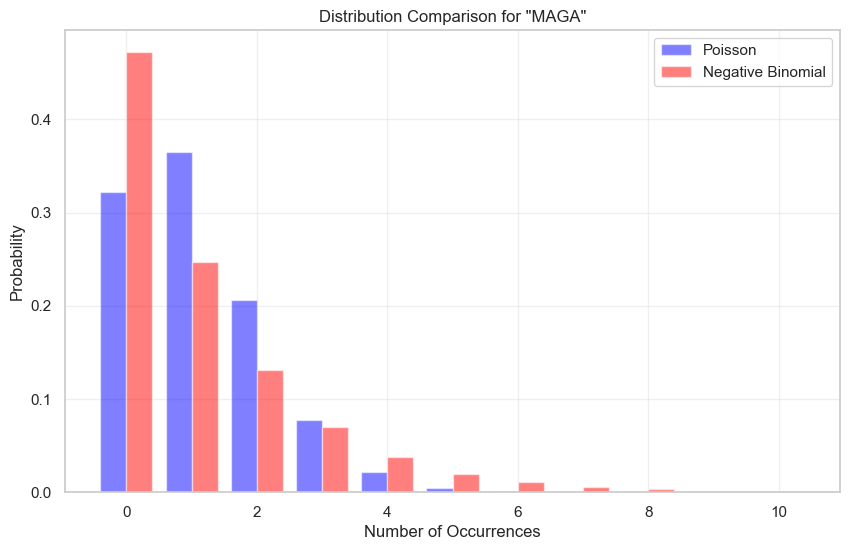


Distribution comparison for Rigged (r = 5.59):


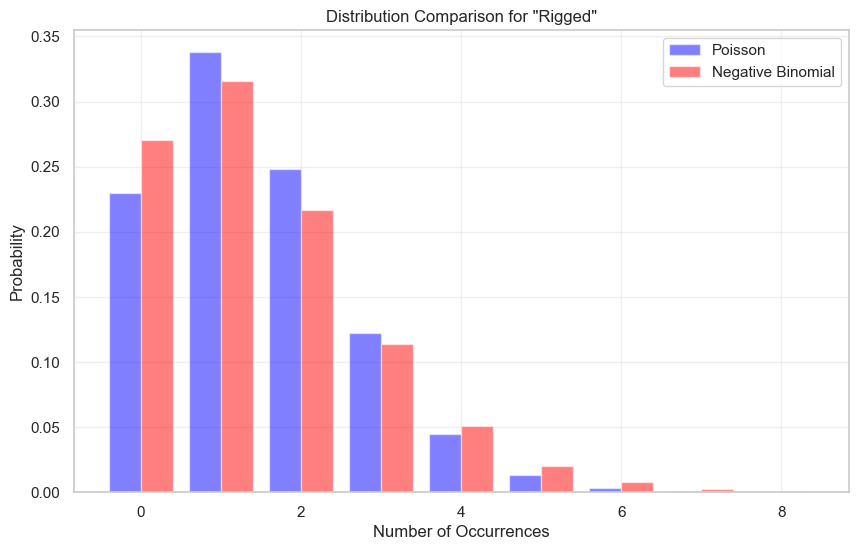


Distribution comparison for Hell (r = 12.86):


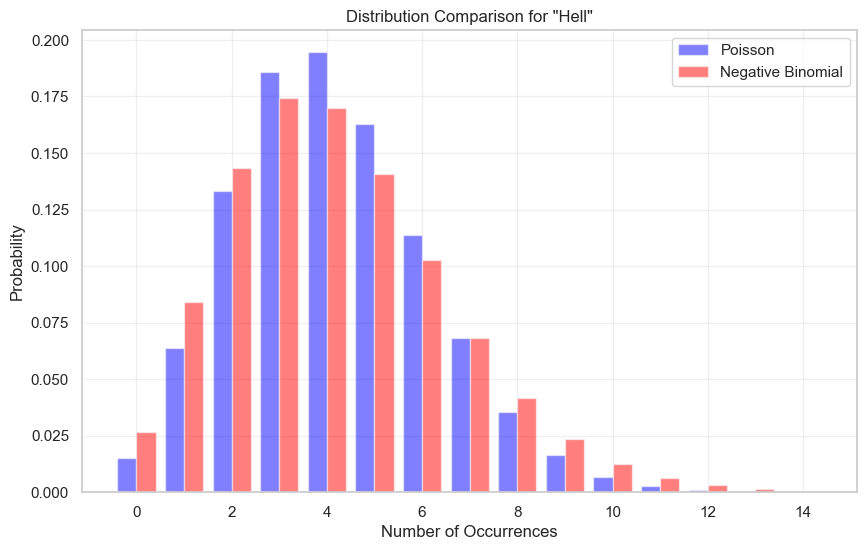

In [97]:

def calculate_negative_binomial_predictions(df, avg_length):
    """Calculate predictions using Negative Binomial distribution"""
    predictions = []
    
    for phrase in SEARCH_PHRASES.keys():
        # Calculate rate per word and variance
        total_occurrences = df[phrase].sum()
        total_words = df['text_length'].sum()
        rate_per_word = total_occurrences / total_words
        
        # Expected occurrences in speech of avg_length
        expected = rate_per_word * avg_length
        
        # Calculate sample variance to estimate overdispersion
        counts_per_speech = df[phrase] / df['text_length'] * avg_length
        sample_variance = counts_per_speech.var()
        
        if sample_variance > expected and expected > 0:  # Check for overdispersion
            # Calculate r parameter for negative binomial using method of moments
            r = max(0.1, expected**2 / (sample_variance - expected))
            p = r/(r + expected)
        else:
            # If no overdispersion, fallback to quasi-Poisson
            r = 100
            p = r/(r + expected)
        
        # Calculate likelihoods using Negative Binomial CDF
        def nb_ge_k(r, p, k):
            return 1 - stats.nbinom.cdf(k-1, r, p)
        
        predictions.append({
            'Phrase': phrase,
            'Expected': expected,
            'Dispersion (r)': r,
            'Sample Variance': sample_variance,
            'P(≥1)': nb_ge_k(r, p, 1),
            'P(≥3)': nb_ge_k(r, p, 3),
            'P(≥4)': nb_ge_k(r, p, 4),
            'P(≥5)': nb_ge_k(r, p, 5),
            'P(≥15)': nb_ge_k(r, p, 15)
        })
    
    return pd.DataFrame(predictions)


def format_prediction_table(df):
    """Format prediction table with percentages"""
    formatted = df.copy()
    formatted = formatted.round(3)
    
    # Format probability columns as percentages
    prob_columns = ['P(≥1)', 'P(≥3)', 'P(≥4)', 'P(≥5)', 'P(≥15)']
    for col in prob_columns:
        formatted[col] = formatted[col].map('{:.1%}'.format)
    
    # Round other numeric columns
    formatted['Expected'] = formatted['Expected'].round(2)
    if 'Dispersion (r)' in formatted.columns:
        formatted['Dispersion (r)'] = formatted['Dispersion (r)'].round(2)
        formatted['Sample Variance'] = formatted['Sample Variance'].round(2)
    
    return formatted.sort_values('Expected', ascending=False)

def compare_models(poisson_df, nb_df):
    """Compare Poisson and Negative Binomial predictions"""
    comparison = pd.DataFrame()
    comparison['Phrase'] = poisson_df['Phrase']
    comparison['Expected'] = poisson_df['Expected']
    
    # Convert percentage strings back to floats for calculations
    for k in [1, 5]:
        # Get raw probability values directly
        comparison[f'Poisson P(≥{k})'] = poisson_df[f'P(≥{k})'].astype(float)
        comparison[f'NB P(≥{k})'] = nb_df[f'P(≥{k})'].astype(float)
        comparison[f'Δ P(≥{k})'] = (comparison[f'NB P(≥{k})'] - comparison[f'Poisson P(≥{k})']) * 100
    
    comparison['Dispersion (r)'] = nb_df['Dispersion (r)']
    comparison['Sample Variance'] = nb_df['Sample Variance']
    
    # Format probability columns as percentages
    for col in comparison.columns:
        if 'P(≥' in col and 'Δ' not in col:
            comparison[col] = comparison[col].map('{:.1%}'.format)
    
    return comparison.round(3).sort_values('Δ P(≥1)', ascending=True)

def plot_distribution_comparison(phrase, poisson_df, nb_df, max_k=10):
    """Plot comparison of Poisson and Negative Binomial distributions"""
    phrase_data = poisson_df[poisson_df['Phrase'] == phrase].iloc[0]
    nb_data = nb_df[nb_df['Phrase'] == phrase].iloc[0]
    
    lambda_ = phrase_data['Expected']
    r = nb_data['Dispersion (r)']
    p = r/(r + lambda_)
    
    k = np.arange(0, max_k+1)
    poisson_pmf = stats.poisson.pmf(k, lambda_)
    nb_pmf = stats.nbinom.pmf(k, r, p)
    
    plt.figure(figsize=(10, 6))
    plt.bar(k-0.2, poisson_pmf, width=0.4, alpha=0.5, label='Poisson', color='blue')
    plt.bar(k+0.2, nb_pmf, width=0.4, alpha=0.5, label='Negative Binomial', color='red')
    plt.title(f'Distribution Comparison for "{phrase}"')
    plt.xlabel('Number of Occurrences')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Calculate predictions using both models
avg_speech_length = df_sotu['text_length'].mean()

print("Negative Binomial Predictions based on all appearances:")
nb_predictions = calculate_negative_binomial_predictions(df, avg_speech_length)
display(format_prediction_table(nb_predictions))

print("Negative Binomial Predictions based on all speeches:")
nb_predictions = calculate_negative_binomial_predictions(df_speech, avg_speech_length)
display(format_prediction_table(nb_predictions))


print("Negative Binomial Predictions based on all appearances post inauguration:")
nb_predictions_all = calculate_negative_binomial_predictions(pd.concat([df_speech_post, df_nonspeech_post]), avg_speech_length)
display(format_prediction_table(nb_predictions_all))

poisson_predictions = calculate_poisson_predictions(df_speech_post, avg_speech_length)

print("\nModel Comparison (Negative Binomial vs Poisson):")
display(compare_models(poisson_predictions, nb_predictions))

# Plot distributions for most overdispersed phrases
most_overdispersed = nb_predictions[nb_predictions['Phrase'].isin(['Border', 'America', 'God', 'January 6', 'MAGA', 'LA', 'Rigged', 'Hell'])]
for _, row in most_overdispersed.iterrows():
    # Get parameters for both distributions
    phrase_data = poisson_predictions[poisson_predictions['Phrase'] == row['Phrase']].iloc[0]
    lambda_ = phrase_data['Expected']
    r = row['Dispersion (r)']
    p = r/(r + lambda_)
    
    # Find where probability becomes negligible (< 0.1%)
    k = 0
    while stats.nbinom.pmf(k, r, p) > 0.001 or stats.poisson.pmf(k, lambda_) > 0.001:
        k += 1
    
    # Ensure minimum k of 30 for 'America' to show full distribution
    if row['Phrase'] == 'America':
        k = max(k, 60)
    
    print(f"\nDistribution comparison for {row['Phrase']} (r = {row['Dispersion (r)']:.2f}):")
    plot_distribution_comparison(row['Phrase'], poisson_predictions, nb_predictions, max_k=k)

## Recent Usage in context

In [98]:
CONTEXT_WINDOW = 200 #WORDS

In [99]:
def get_recent_contexts(df, phrase, n=5):
    """Get the n most recent contexts for a phrase"""
    # Create a list to store matches with their dates
    all_matches = []
    
    # Look through speeches from newest to oldest
    for _, row in df.sort_values('date', ascending=False).iterrows():
        matches = find_phrase_context(row['text'], SEARCH_PHRASES[phrase])
        for match in matches:
            all_matches.append({
                'date': row['date'],
                'category': row['category'],
                'context': match
            })
        if len(all_matches) >= n:
            break
    
    return pd.DataFrame(all_matches[:n])

# Get recent contexts for each phrase
for phrase in SEARCH_PHRASES.keys():
    contexts = get_recent_contexts(df, phrase)
    if not contexts.empty:
        print(f"\n=== Recent usage of '{phrase}' ===\n")
        for _, row in contexts.iterrows():
            print(f"Date: {row['date'].strftime('%Y-%m-%d')} ({row['category']})")
            print(f"Context: {row['context']}\n")


=== Recent usage of 'Immigration' ===

Date: 2025-02-07 (press conference)
Context: ...be looking at military, too.

Absolutely.

Well, they don't really have to be looked at by him. They can be looked at by us. Social Security will not be touched. It will only be strengthened. We have illegal immigrants on Social Security and we're going to find out who they are and take them out. We have, uh, illegal immigrants in other Medicare.

We have -- uh, we found a lot of bad people, a lot of people that sh...

Date: 2025-02-07 (press conference)
Context: ...ked at by us. Social Security will not be touched. It will only be strengthened. We have illegal immigrants on Social Security and we're going to find out who they are and take them out. We have, uh, illegal immigrants in other Medicare.

We have -- uh, we found a lot of bad people, a lot of people that shouldn't be on that were put on when -- through California. They come -- a lot of them come out of California.

...

Date: 2025-02-07 (

In [100]:
get_recent_contexts(df, 'Trans', 20)

,date,category,context
0,2024-10-10,speech,"... we're not making the deal."" And I got it, and it's coming due very soon. Oh, I'm going to have a lot of fun. And that will address these concerns. And I will also seek strong new protections against trans shipments so that China and other countries cannot smuggle their products and auto parts into the United States tax-free through Mexico.\n\nTo the detriment of our workers and our supply chains, they s..."
1,2024-04-02,speech,"...o win this state, we're going to win the White House, and we are going to save our country.\n\nWe're going to save our country. And what the hell was Biden thinking when he declared Easter Sunday to be Trans Visibility Day?\n\nSuch total disrespect to Christians. And November 5th is going to be called something else. You know, what it's going to be called? Christian Visibility Day when Christians turn out ..."


## Per-Speech Frequencies


In [120]:
def analyze_speech_frequencies(df, sotu_mean_length):
    """Analyze frequency of phrases in individual speeches"""
    # Filter out length outliers (more than 2x SOTU length)
    df_filtered = df[(df['text_length'] >= 0.5 * sotu_mean_length) & (df['text_length'] <= 2 * sotu_mean_length)].copy()
    
    results = []
    for phrase in SEARCH_PHRASES.keys():
        result = {
            'Phrase': phrase,
            'Total Speeches': len(df_filtered),
            'P(≥1)': (df_filtered[phrase] >= 1).mean(),
            'P(≥3)': (df_filtered[phrase] >= 3).mean(),
            'P(≥4)': (df_filtered[phrase] >= 4).mean(),
            'P(≥5)': (df_filtered[phrase] >= 5).mean(),
            'P(≥15)': (df_filtered[phrase] >= 15).mean(),
            'Max Occurrences': df_filtered[phrase].max(),
            'Mean Occurrences': df_filtered[phrase].mean()
        }
        results.append(result)
    
    return pd.DataFrame(results)

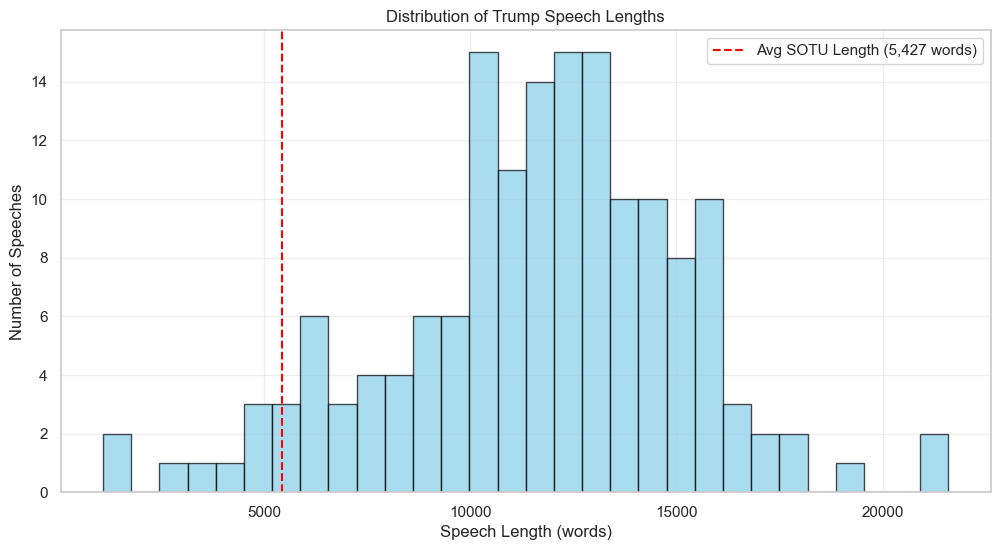

In [112]:
sotu_mean_length = df_sotu['text_length'].mean()

# Plot distribution of speech lengths with SOTU average marked
plt.figure(figsize=(12, 6))
plt.hist(df_speech['text_length'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=sotu_mean_length, color='red', linestyle='--', label=f'Avg SOTU Length ({int(sotu_mean_length):,} words)')
plt.xlabel('Speech Length (words)')
plt.ylabel('Number of Speeches')
plt.title('Distribution of Trump Speech Lengths')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


we do some filtering by length: inlude transcripts between half and double the average SOTU length (somewhat arbitrary)

In [121]:
# Calculate and display per-speech frequencies for different subsets
all_freq_df = analyze_speech_frequencies(df, sotu_mean_length)
post_freq_df = analyze_speech_frequencies(pd.concat([df_speech_post, df_nonspeech_post]), sotu_mean_length)
speech_freq_df = analyze_speech_frequencies(df_speech, sotu_mean_length)

# Sort by probability of at least one occurrence
all_freq_df = all_freq_df.sort_values('P(≥1)', ascending=False)
post_freq_df = post_freq_df.sort_values('P(≥1)', ascending=False)
speech_freq_df = speech_freq_df.sort_values('P(≥1)', ascending=False)

# Format percentages for each dataframe
for df in [all_freq_df, post_freq_df, speech_freq_df]:
    for col in ['P(≥1)', 'P(≥3)', 'P(≥4)', 'P(≥5)', 'P(≥15)']:
        df[col] = df[col].map('{:.1%}'.format)

# Display results
print("All Appearances:")
display(all_freq_df)
print("\nAll Speeches:")
display(speech_freq_df)
print("\nPost-Inauguration Appearances:")
display(post_freq_df)



All Appearances:


,Phrase,Total Speeches,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15),Max Occurrences,Mean Occurrences
2,America,87,92.0%,71.3%,69.0%,64.4%,39.1%,38,11.816092
3,Border,87,89.7%,75.9%,67.8%,64.4%,40.2%,72,12.436782
11,Biden,87,88.5%,70.1%,60.9%,54.0%,14.9%,48,7.896552
24,Hell,87,77.0%,54.0%,51.7%,43.7%,8.0%,23,5.620690
17,MAGA,87,63.2%,27.6%,17.2%,14.9%,0.0%,11,1.954023
23,Israel,87,63.2%,21.8%,18.4%,11.5%,5.7%,58,3.540230
8,God,87,57.5%,42.5%,25.3%,13.8%,1.1%,21,2.298851
20,Rigged,87,54.0%,27.6%,17.2%,9.2%,0.0%,9,1.643678
0,Immigration,87,51.7%,19.5%,8.0%,6.9%,0.0%,10,1.287356
26,Mexico,87,50.6%,34.5%,27.6%,24.1%,0.0%,12,2.356322



All Speeches:


,Phrase,Total Speeches,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15),Max Occurrences,Mean Occurrences
3,Border,54,98.1%,92.6%,85.2%,83.3%,57.4%,72,16.981481
2,America,54,96.3%,90.7%,90.7%,87.0%,55.6%,34,15.500000
24,Hell,54,92.6%,77.8%,75.9%,68.5%,13.0%,23,8.388889
11,Biden,54,92.6%,81.5%,70.4%,61.1%,24.1%,48,10.462963
17,MAGA,54,81.5%,40.7%,25.9%,24.1%,0.0%,11,2.814815
8,God,54,79.6%,59.3%,35.2%,18.5%,1.9%,21,3.203704
20,Rigged,54,70.4%,38.9%,24.1%,13.0%,0.0%,9,2.185185
23,Israel,54,68.5%,25.9%,20.4%,13.0%,9.3%,58,4.888889
0,Immigration,54,64.8%,20.4%,5.6%,3.7%,0.0%,6,1.296296
21,Mandate,54,61.1%,20.4%,11.1%,5.6%,0.0%,5,1.277778



Post-Inauguration Appearances:


,Phrase,Total Speeches,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15),Max Occurrences,Mean Occurrences
11,Biden,28,89.3%,57.1%,50.0%,46.4%,0.0%,12,4.250000
2,America,28,78.6%,42.9%,35.7%,32.1%,10.7%,21,4.535714
3,Border,28,75.0%,42.9%,32.1%,25.0%,3.6%,21,3.178571
24,Hell,28,64.3%,25.0%,21.4%,10.7%,0.0%,10,1.785714
27,Canada,28,53.6%,35.7%,28.6%,28.6%,7.1%,25,3.785714
13,LA,28,46.4%,17.9%,10.7%,10.7%,0.0%,7,1.285714
9,Elon,28,39.3%,17.9%,7.1%,3.6%,0.0%,7,1.035714
29,Gaza,28,35.7%,25.0%,25.0%,21.4%,0.0%,11,2.107143
23,Israel,28,35.7%,10.7%,10.7%,10.7%,0.0%,7,1.071429
26,Mexico,28,32.1%,14.3%,14.3%,10.7%,0.0%,8,1.107143


## Individual Phrase Analysis

In [87]:
# Find speeches shorter than 6000 words with 4+ mentions of MAGA
short_maga_speeches = df[
    (df['text_length'] < 10200) & 
    (df['MAGA'] >= 4)
][['file', 'text_length', 'MAGA']]

print(f"\nSpeeches under 10200 words with 4+ mentions of MAGA:")
print(short_maga_speeches.sort_values('MAGA', ascending=False))

KeyError: 'text_length'

In [51]:
df[df['January 6'] > 0][['file', 'text_length', 'January 6', 'category']]

,file,text_length,January 6,category
72,2024-01-14_donald_trump_holds_a_political_rally_in_indianola_iowa.txt,15943,1,speech
66,2024-01-19_donald_trump_holds_a_political_rally_in_concord_new_hampshire.txt,15275,1,speech
186,2024-01-20_donald_trump_holds_a_political_rally_in_manchester_new_hampshire.txt,14227,1,speech
63,2024-01-22_donald_trump_holds_a_political_rally_in_laconia_new_hampshire.txt,11312,1,speech
146,2024-02-10_donald_trump_holds_a_political_rally_in_conway_south_carolina.txt,15185,1,speech
62,2024-02-14_donald_trump_holds_a_political_rally_in_north_charleston_south_carolina.txt,14710,1,speech
160,2024-02-23_donald_trump_holds_a_political_rally_in_rock_hill_south_carolina.txt,13553,2,speech
55,2024-03-02_donald_trump_holds_a_political_rally_in_richmond_virginia.txt,13998,2,speech
177,2024-03-02_donald_trump_holds_a_political_rally_in_greensboro_north_carolina.txt,11588,2,speech
129,2024-03-09_donald_trump_holds_a_political_rally_in_rome_georgia.txt,17035,1,speech


In [52]:
df[df['LA'] > 0][['file', 'text_length', 'LA', 'category']].sort_values('file')

,file,text_length,LA,category
169,2023-09-29_donald_trump_addresses_a_california_gop_lunch_event_in_anaheim.txt,15552,4,speech
199,2023-10-01_donald_trump_holds_a_campaign_event_in_ottumwa_iowa.txt,13209,1,speech
65,2023-10-07_donald_trump_holds_a_campaign_rally_in_waterloo_iowa.txt,10179,1,speech
105,2023-10-11_donald_trump_addresses_his_club_47_fan_club_in_west_palm_beach_florida.txt,17529,1,speech
156,2023-12-17_donald_trump_holds_a_political_rally_in_reno_nevada.txt,10979,1,speech
83,2024-01-05_donald_trump_holds_a_campaign_rally_in_sioux_center_iowa.txt,19189,2,speech
115,2024-01-06_donald_trump_holds_a_campaign_event_in_clinton_iowa.txt,11001,1,speech
66,2024-01-19_donald_trump_holds_a_political_rally_in_concord_new_hampshire.txt,15275,1,speech
198,2024-01-21_donald_trump_holds_a_political_rally_in_rochester_new_hampshire.txt,13102,2,speech
63,2024-01-22_donald_trump_holds_a_political_rally_in_laconia_new_hampshire.txt,11312,1,speech


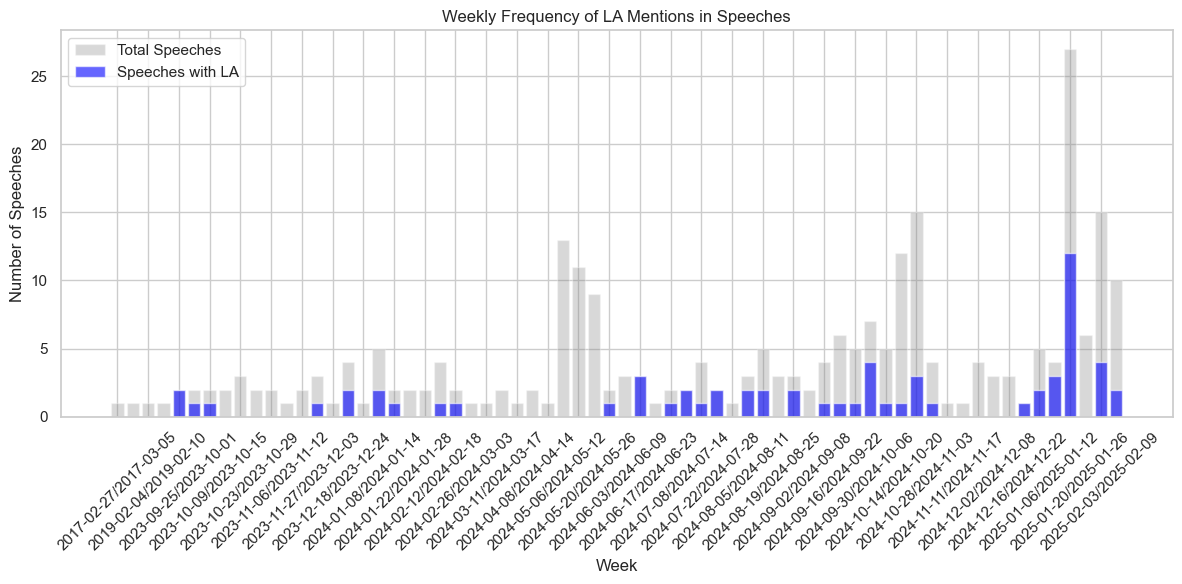

In [53]:
# Convert date strings to datetime 
df['date'] = pd.to_datetime(df['date'])

# Create weekly bins
df['week'] = df['date'].dt.to_period('W')

# Group by week and calculate metrics
weekly_stats = df.groupby('week').agg({
    'file': 'count',  # Total speeches per week
    'LA': lambda x: (x > 0).sum()  # Speeches containing LA per week
}).reset_index()

# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for speech counts
ax.bar(range(len(weekly_stats)), weekly_stats['file'], alpha=0.3, color='gray', label='Total Speeches')
ax.bar(range(len(weekly_stats)), weekly_stats['LA'], alpha=0.6, color='blue', label='Speeches with LA')

# Customize axes
ax.set_xlabel('Week')
ax.set_ylabel('Number of Speeches')

# Set x-axis ticks to show dates every 2 weeks
tick_indices = range(0, len(weekly_stats), 2)
plt.xticks(tick_indices, [str(weekly_stats['week'].iloc[i]) for i in tick_indices], rotation=45)

# Add legend
ax.legend(loc='upper left')

plt.title('Weekly Frequency of LA Mentions in Speeches')
plt.tight_layout()
plt.show()
